In [1]:
#import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pm4py
import seaborn as sns
import math
# Log Conversion (pandas to log and vice versa)
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import factory as log_conv
from pm4py.util import constants
from pm4py.util.business_hours import BusinessHours
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.conversion.log import converter as log_conversion
from pm4py.objects.log.util import interval_lifecycle
# for prediction task
from datetime import datetime
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [22]:
# Path to the directory in which you should save you images (models and 
# other important analysis outputs where zooming in with an external program might be interesting)
path_save_process_discovery_base = os.path.abspath('./figures/process_discovery')

# Step 1: Load Data from event log and preprocess it

The goal of this master thesis is to illustrate how process mining techniques can be combined with machine learning techniques to add explainability to the predictions to the previously black box prediction models.

In [2]:
def read_file(filename, outputfilename):
    """
    loads event log data frame from file_name which is realtive path
    """
    df = pd.read_csv(filename)
    df.to_csv(outputfilename,index=False)  
    return df

In [3]:
def rename_columns(df):
    """
    renames xes standard columns to standard keys that are used in predictive process minitoring code 
    e.g. org:resource to Resource
    
    """
    cols = {"case:concept:name":"Case ID", "concept:name":"Activity", "time:timestamp":"Start Timestamp", "org:resource":"Resource"}
    df.rename(columns = cols, inplace = True)
    return df

In [4]:
def read_file_xes_format(filename, outputfilename):
    """
    reads files in xes format and converts them into suitable dataframe
    """
    log = xes_importer.apply(filename)
    dataframe = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
    dataframe = rename_columns(dataframe)
    dataframe.to_csv(outputfilename,index=False)  
    return dataframe

In [5]:
def preprocess_df(df):
    """
    Preprocessing function that parses the timestamps and resource information.
    :df: DataFrame that should be processed
    :returns: Preprocessed DataFrame
    """
    # Convert start timestamp
    df["Start Timestamp"] = pd.to_datetime(df['Start Timestamp'],utc=True).dt.tz_convert(None)
    # Convert end timestamp
    if("Complete Timestamp" in df.columns):
        df['Complete Timestamp'] = pd.to_datetime(df['Complete Timestamp'], utc=True).dt.tz_convert(None)
    # if resource is an int convert to string
    if (("Complete Timestamp" in df.columns) and (df["Resource"].dtype in ['int64', 'float64'])):
        df["Resource"] = df["Resource"].astype('str')
    return df

In [16]:
#fill missing values ( taken from https://github.com/PyRicky/LSTM_Generic_explainable/blob/master/load_dataset.py )
# TODO ....
def fill_missing_end_dates(df, start_date_position, end_date_position):
    df[df.columns[end_date_position]] = df.apply(lambda row: row[start_date_position]
                  if row[end_date_position] == 0 else row[end_date_position], axis=1)
    return df

In [7]:
def sort_df(df):
    df.sort_values(["Case ID","Start Timestamp"], axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
    return df

# Preprocess Raw Event Logs File

In [10]:
#Prepare event Logs that are in csv format already and save to prepared_data folder

In [ ]:
filenames = ["Production_Data.csv", "bpi12a", "bpi12o", "bpi12w"]
for f in filenames:
    filename = "data/"+f
    outputfilename = "prepared_data/"+ f
    df = read_file(filename, outputfilename)
    df = preprocess_df(df)
    df = sort_df(df)

In [11]:
# Prepare Event Log Files which are in XES Format and save to prepared_data folder

In [ ]:
filename = 'data/Road_Traffic_Fine_Management_Process.xes.gz'
outputfilename = 'prepared_data/traffic_fines.csv'
df = read_file_xes_format(filename, outputfilename)

In [8]:
filename = 'data/DomesticDeclarations.xes.gz'
outputfilename = 'prepared_data/bpi20.csv'
df = read_file_xes_format(filename, outputfilename)

In [9]:
df.head()

,id,Resource,Activity,Start Timestamp,org:role,case:id,Case ID,case:BudgetNumber,case:DeclarationNumber,case:Amount
0,st_step 86794_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:49:50+01:00,EMPLOYEE,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
1,st_step 86793_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 11:27:48+01:00,SUPERVISOR,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
2,dd_declaration 86791_19,SYSTEM,Request Payment,2017-01-10 09:34:44+01:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
3,dd_declaration 86791_20,SYSTEM,Payment Handled,2017-01-12 17:31:22+01:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
4,st_step 86798_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 10:26:14+01:00,EMPLOYEE,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172


# Load Event Log For Which you Want to Predict

In [13]:
def load_event_log(filename):
    df = pd.read_csv(filename)
    df = preprocess_df(df)
    df = sort_df(df)
    return df

In [9]:
#interesting event logs are bpi20.csv (paper relevant), traffic_fines.csv ( paper relevant), Production_Data.csv(IoT relevant)

In [27]:
filename = 'traffic_fines.csv'

In [28]:
df = load_event_log(filename = 'prepared_data/'+filename)
df.head()

,amount,Resource,dismissal,Activity,vehicleClass,totalPaymentAmount,lifecycle:transition,Start Timestamp,article,points,Case ID,expense,notificationType,lastSent,paymentAmount,matricola
0,35.0,561.0,NIL,Create Fine,A,0.0,complete,2006-07-23 22:00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-04 23:00:00,NaN,NaN,A1,11.0,NaN,NaN,NaN,NaN
2,35.0,561.0,NIL,Create Fine,A,0.0,complete,2006-08-01 22:00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-11 23:00:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-14 23:00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN


In [29]:
#check for missing values
df[df.isna().any(axis=1)]

,amount,Resource,dismissal,Activity,vehicleClass,totalPaymentAmount,lifecycle:transition,Start Timestamp,article,points,Case ID,expense,notificationType,lastSent,paymentAmount,matricola
0,35.0,561.0,NIL,Create Fine,A,0.0,complete,2006-07-23 22:00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-04 23:00:00,NaN,NaN,A1,11.00,NaN,NaN,NaN,NaN
2,35.0,561.0,NIL,Create Fine,A,0.0,complete,2006-08-01 22:00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-11 23:00:00,NaN,NaN,A100,11.00,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-14 23:00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561465,131.0,25.0,NIL,Create Fine,A,0.0,complete,2002-09-06 22:00:00,142.0,0.0,V9999,NaN,NaN,NaN,NaN,NaN
561466,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2002-10-24 22:00:00,NaN,NaN,V9999,15.16,NaN,NaN,NaN,NaN
561467,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2002-11-03 23:00:00,NaN,NaN,V9999,NaN,P,N,NaN,NaN
561468,262.0,NaN,NaN,Add penalty,NaN,NaN,complete,2003-01-02 23:00:00,NaN,NaN,V9999,NaN,NaN,NaN,NaN,NaN


# Explore Process Itself using Process Discovery Techniques

In [17]:
 param_keys={constants.PARAMETER_CONSTANT_CASEID_KEY: 'Case ID',
        constants.PARAMETER_CONSTANT_RESOURCE_KEY: 'Resource', 
        constants.PARAMETER_CONSTANT_ACTIVITY_KEY: 'Activity',
        constants.PARAMETER_CONSTANT_START_TIMESTAMP_KEY: 'Start Timestamp',
        constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: 'Complete Timestamp'}

In [18]:
def convert_df_to_log(df):
    #convert to log
    # Mapping between dataset columns and PM4Py keys
    # Many functions will require you to pass this as additional parameters
    log = log_conv.apply(df, parameters=param_keys)
    return log   

# EDA of process

In [30]:
# first convert datafarme into log with parameters to run pm4py library functions
log = convert_df_to_log(df)

C:\Users\Shreya Kar\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecatedWarning: apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use algorithm entrypoint instead
  """


C:\Users\Shreya Kar\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecatedWarning: apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use visualizer module instead.
  
C:\Users\Shreya Kar\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecatedWarning: view is deprecated as of 1.3.0 and will be removed in 2.0.0. Use visualizer module instead.
  import sys


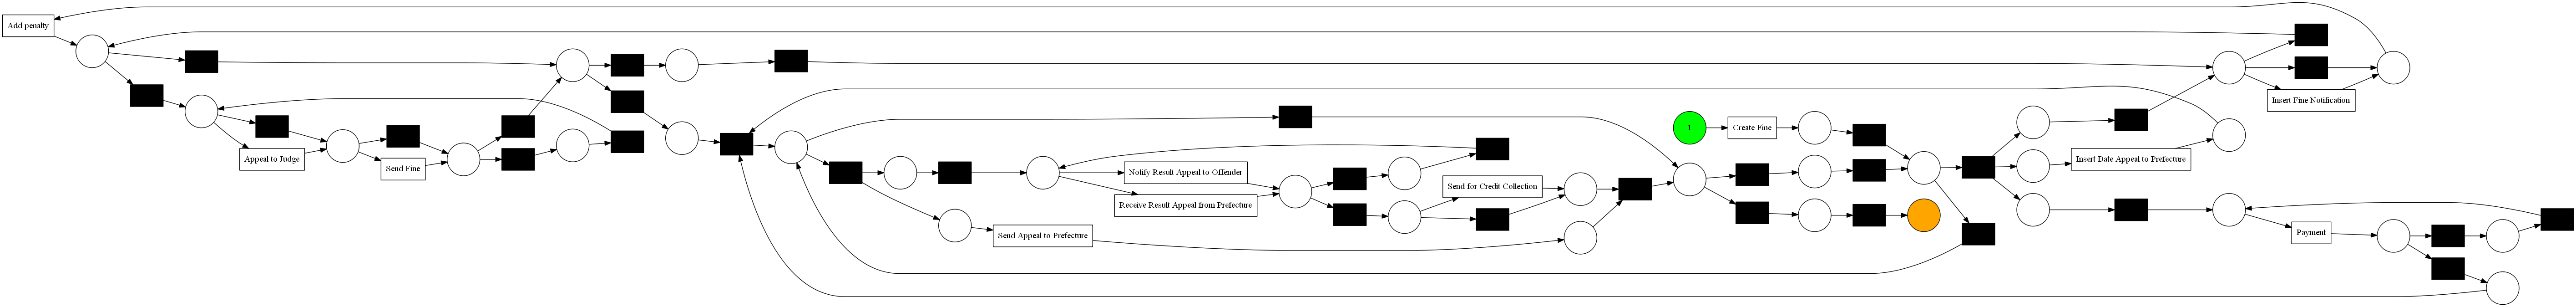

C:\Users\Shreya Kar\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecatedWarning: save is deprecated as of 1.3.0 and will be removed in 2.0.0. Use visualizer module instead.
  


In [31]:
# process model discovery using inductive miner technique to give idea of process
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petrinet import factory as pn_vis_factory
net, initial_marking, final_marking = inductive_miner.apply(log, parameters = param_keys)
#visualize process model as a petri net
gviz = pn_vis_factory.apply(net, initial_marking, final_marking)
pn_vis_factory.view(gviz)
pn_vis_factory.save(gviz, os.path.join(path_save_process_discovery_base, filename+'_model.png'))

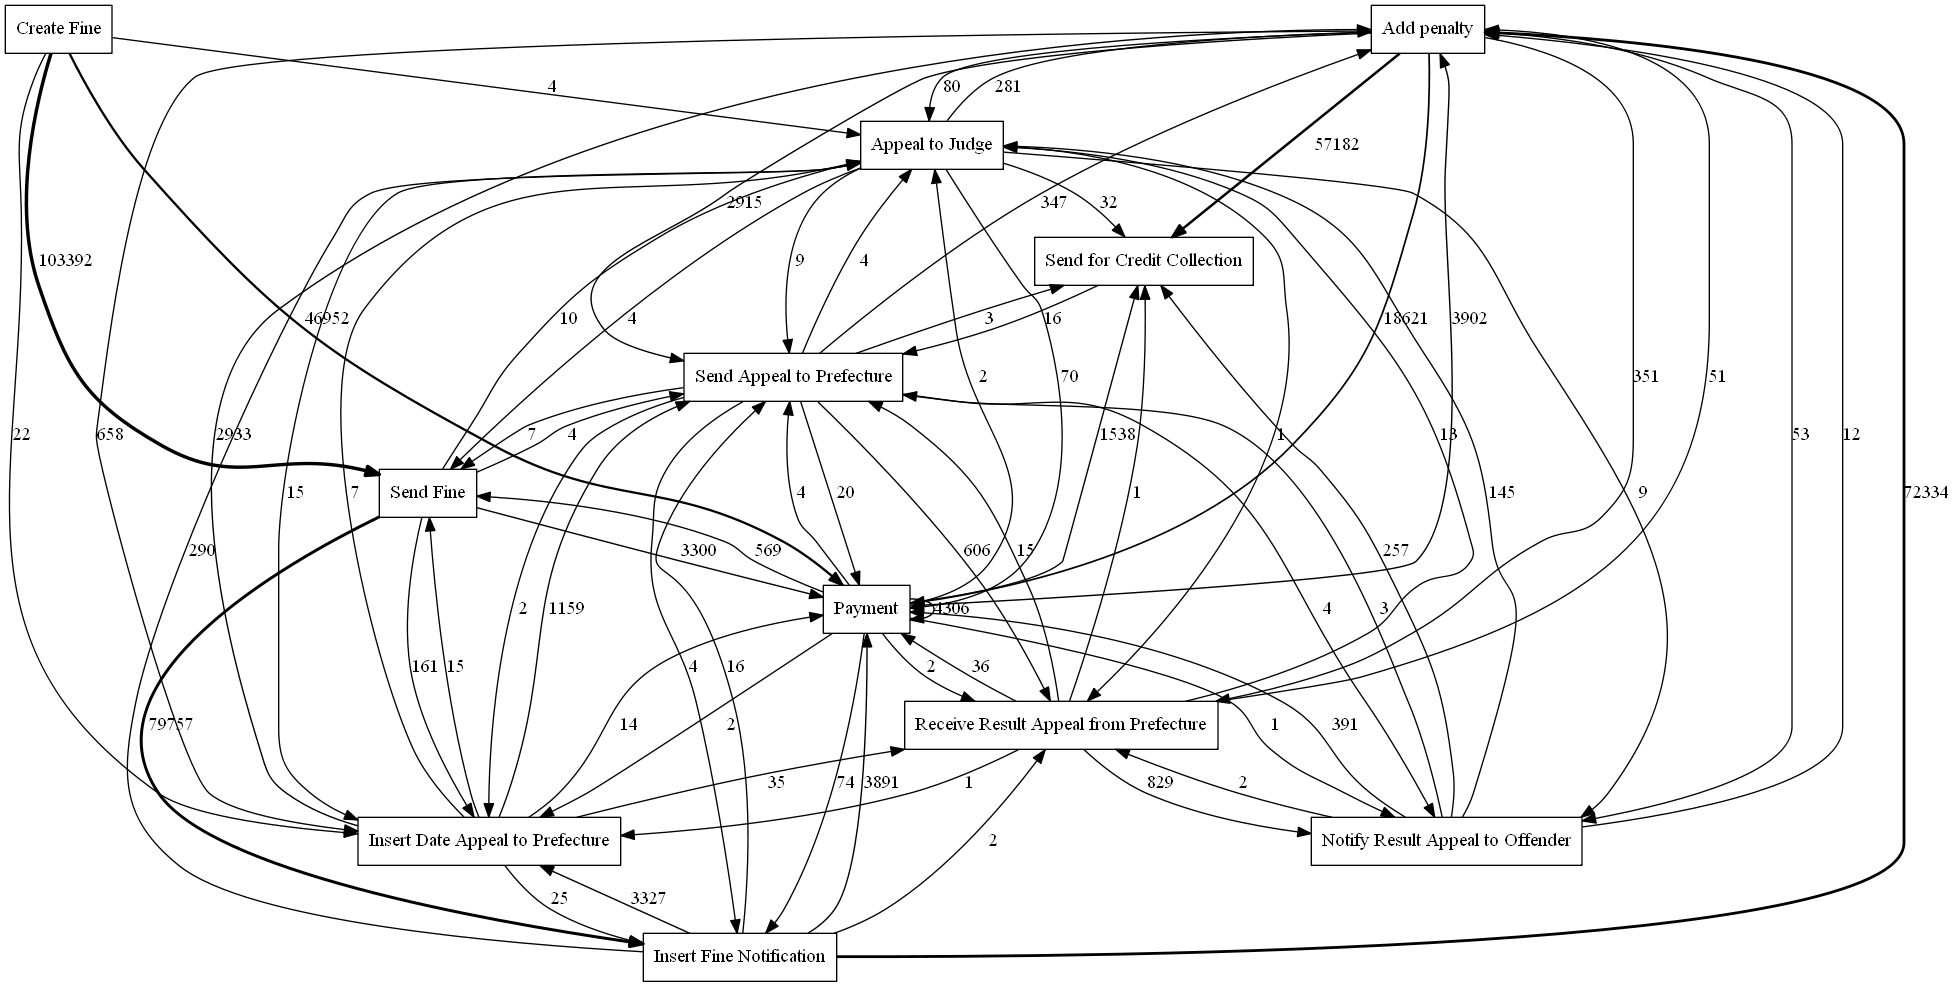

C:\Users\Shreya Kar\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecatedWarning: save is deprecated as of 1.3.0 and will be removed in 2.0.0. Use visualizer module instead.
  


In [32]:
#visualize directly follow activities of a process with their frequncies written on transition arcs
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
dfg = dfg_discovery.apply(log, parameters = param_keys)

from pm4py.visualization.dfg import visualizer as dfg_visualization
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)
pn_vis_factory.save(gviz, os.path.join(path_save_process_discovery_base, filename+'_dfg.png'))

# Examine most common Variants or Process Traces

In [35]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics

def get_variants_dict(log):
    variants = variants_filter.get_variants(log, parameters = param_keys)
    variants_count = case_statistics.get_variant_statistics(log, parameters = param_keys)
    variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)
    return variants_count

In [38]:
variants_count = get_variants_dict(log)
print("number of variants of process seen %s", len(variants_count))
print("top 10 process variants and its frequency")
variants_count[:5]

number of variants of process seen %s 231
top 10 process variants and its frequency


[{'variant': 'Create Fine,Send Fine,Insert Fine Notification,Add penalty,Send for Credit Collection',
  'count': 56482},
 {'variant': 'Create Fine,Payment', 'count': 46371},
 {'variant': 'Create Fine,Send Fine', 'count': 20385},
 {'variant': 'Create Fine,Send Fine,Insert Fine Notification,Add penalty,Payment',
  'count': 9520},
 {'variant': 'Create Fine,Send Fine,Insert Fine Notification,Add penalty,Payment,Payment',
  'count': 3736}]

# Set Parameters for Plot Sizes 

In [12]:
plt.rcParams['agg.path.chunksize'] = 10000

# Step 1.1 Explore Segment Wise Distribution using Performance Spectrum

In [13]:
# function to return directly follow activities and frequency as a list as well as plot the distribution of frequencies
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
def return_dfg_activities(log):
    dfg = dfg_discovery.apply(log, parameters=param_keys)
    plt.hist(x=dfg.values(),bins=50)
    plt.title("Distribution of Directly Follow Activities Frequencies")
    plt.show()
    threshold = 15
    return dfg,threshold

In [14]:
def check_if_dfg_in_activities(activities,dfg_activities):
    if dfg_activities[0] in activities:
        if dfg_activities[1] in activities:
            return True
        else:
            return False
    else:
        return False          

In [15]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [16]:
def return_observations(t,segment_data):
    temp = segment_data[:t]
    temp = temp[temp["batch"]!=0]
    k = temp.groupby("batch").count().values
    return k

In [17]:
# case belongs to which batch
# timestamps where batching occurs
def prepare_segment_df(segment_df):
    """
        returns segment_df without 
    """
     #count the number of obseravtions
    segment_data = segment_df
    segment_data["observations"] = np.repeat(1,segment_df.shape[0])
    segment_data["observations"] = segment_data["observations"].cumsum()
    
    #count mean and variance of number of observations in a batch
    #rows = range(1,segment_df.shape[0])
    #k = list(map(lambda x: return_observations(x,segment_data), rows))
#     batch_info = pd.get_dummies(segment_df["batch"])
#     k = np.cumsum(batch_info.loc[:,1:].values,axis=0)
#     segment_data["mean_k"] = np.mean(k,axis=1)
#     segment_data["std_k"] = np.std(k,axis=1)
#     #add number of batches
#     segment_data["m"] = np.sum(np.where(k==0, k,1),axis=1)
    # add batching frequency
    #b = batch_info.loc[:,0].values
#     segment_data["BF"] = np.divide(np.cumsum(segment_data["is_batch"].values),segment_data["observations"].values)
    #statistics of waiting times of non batched and batched elements
    #segment_data["tb"] = segment_data["tb"].dt.tz_convert(None)
    #segment_data["ta"] = segment_data["ta"].dt.tz_convert(None)
    segment_data["waiting_time"] = (segment_data["tb"]-segment_data["ta"]).dt.total_seconds()
#     segment_data["IA"] = segment_data["ta"].diff().dt.total_seconds().fillna(0).values
    #waiting_times = batch_info.loc[:,1].mul(segment_data["waiting_time"],0)
    
    
    # add mean and variance of batching interval
#     batch_intervals = batch_info
#     seconds = np.cumsum(segment_data["tb"].diff().dt.total_seconds().fillna(0).values)
#     segment_data["tb_seconds"] = seconds.astype('int')
#     batch_intervals = pd.get_dummies(segment_data["batch"]).mul(segment_data["tb_seconds"],0)
#     batch_intervals = batch_intervals.diff().fillna(0)
#     batch_intervals[batch_intervals<0] = 0
#     batch_intervals = np.cumsum(batch_intervals,axis=0).loc[:,1:]
#     batch_intervals = np.diff(batch_intervals)
#     batch_intervals[batch_intervals<0] = 0
#     observations = np.sum(np.where(k==0, k,1),axis=1)-np.repeat(1,segment_data.shape[0])
#     observations[observations<=0] = 1
#     segment_data["mean_BI"] = np.divide(np.sum(batch_intervals,axis=1),observations)
    #segment_data["mean_BI"].fillna(0,inplace=True)
    #segment_data["std_BI"] = np.std(batch_intervals,axis=1)
    return segment_data
    

In [18]:
def detect_batches(segment_df, batch_delay='1H'):
    '''
        kmin, y
        return timestamp with batches
    '''
    temp = segment_df.reset_index()
    temp = temp[["Case ID", "tb"]].set_index("tb")
    #temp["Case ID"]= temp["Case ID"].apply(list)
    temp1 = temp.resample(batch_delay).apply(list)
    temp1["batch_size"] = temp1["Case ID"].apply(len)
    batches = temp1[temp1["batch_size"]>1]["Case ID"].values
    case_batch_dict = dict()
    for i,batch in enumerate(batches):
        for case in batch:
            case_batch_dict[case]=i+1
    temp["is_batch"] = temp["Case ID"].apply(lambda x: 1 if x in case_batch_dict.keys() else 0)
    #0 if not in a batch
    temp["batch"] = temp["Case ID"].apply(lambda x: case_batch_dict.get(x,0))
    temp["ta"] = pd.to_datetime(segment_df["ta"].values)
    temp["segment"] = segment_df["segment"].values
    return temp.reset_index()

In [19]:
def plot_performance_spectrum(data,a1,a2,axs,i,resource_key,segment, batch_delay):
    cases = data.groupby("Case ID")["Activity"].apply(list).apply(lambda x: check_if_dfg_in_activities(x,[a1,a2])).reset_index(name="dfg_present")
    valid_cases = cases[cases["dfg_present"]==True]["Case ID"].unique()
    filter_df1 = data[(data["Activity"]== a1) & (data["Case ID"].isin(valid_cases))]
    filter_df2 = data[(data["Activity"]== a2) & (data["Case ID"].isin(valid_cases))]
    resource_df = filter_df1.groupby(["Case ID"])[resource_key].first().reset_index(name="resources")
    filter_df1 = filter_df1.groupby(["Case ID"])["Start Timestamp"].min().reset_index(name="ta")
    filter_df2 = filter_df2.groupby(["Case ID"])["Start Timestamp"].min().reset_index(name="tb")
    filter_df = filter_df1.set_index("Case ID").join(filter_df2.set_index("Case ID"))
    filter_df = filter_df[filter_df["ta"]<=filter_df["tb"]]
    #print(filter_df.head())
    if(not filter_df.empty):
        times = filter_df.values
        x_values = np.array(sorted(times, key = lambda x: (x[0],x[1])))
        filter_df = pd.DataFrame({"ta": x_values[:,0], "tb": x_values[:,1],"segment":np.repeat(segment,filter_df.shape[0])}, index=filter_df.index)
        #segment_df = detect_batches(filter_df, batch_delay)
        # pass segment_df
        segment_data = prepare_segment_df(filter_df)
        return segment_data
    else:
        return filter_df

In [20]:
def plot_performance_spectrum_complete_timestamp(data,a1,a2,axs,i,resource_key,segment, batch_delay):
    cases = data.groupby("Case ID")["Activity"].apply(list).apply(lambda x: check_if_dfg_in_activities(x,[a1,a2])).reset_index(name="dfg_present")
    valid_cases = cases[cases["dfg_present"]==True]["Case ID"].unique()
    filter_df1 = data[(data["Activity"]== a1) & (data["Case ID"].isin(valid_cases))]
    filter_df2 = data[(data["Activity"]== a2) & (data["Case ID"].isin(valid_cases))]
    resource_df = filter_df1.groupby(["Case ID"])[resource_key].first().reset_index(name="resources")
    filter_df1 = filter_df1.groupby(["Case ID"])["Complete Timestamp"].min().reset_index(name="ta")
    filter_df2 = filter_df2.groupby(["Case ID"])["Complete Timestamp"].min().reset_index(name="tb")
    filter_df = filter_df1.set_index("Case ID").join(filter_df2.set_index("Case ID"))
    filter_df = filter_df[filter_df["ta"]<=filter_df["tb"]]
    #print(filter_df.head())
    if(not filter_df.empty):
        times = filter_df.values
        x_values = np.array(sorted(times, key = lambda x: (x[0],x[1])))
        filter_df = pd.DataFrame({"ta": x_values[:,0], "tb": x_values[:,1],"segment":np.repeat(segment,filter_df.shape[0])}, index=filter_df.index)
        #segment_df = detect_batches(filter_df, batch_delay)
        # pass segment_df
        segment_data = prepare_segment_df(filter_df)
        return segment_data
    else:
        return filter_df

In [21]:
# filter dfg activities for important segments using thresholds
def get_dfg_activities(df):
    log = convert_df_to_log(df)
    dfg,threshold = return_dfg_activities(log)
    dfg_activities_unique = list(dfg.keys())
    #dfg_activities_unique = list(filter(lambda x:(x[0]!=x[1]) and (dfg.get(x)>16),dfg_activities))
    segment_dict = dict()
    i=1
    for val in dfg_activities_unique:
        segment_dict[val]=i
        i=i+1
    return segment_dict, dfg_activities_unique

In [22]:
def get_segment_statistics(df,segment_dict,dfg_activities_unique):
    n = len(dfg_activities_unique[:])
    i = 0
    axs="plt"
    df_list = []
    for a1,a2 in dfg_activities_unique[:]:
        #print(a1,a2)
        segment= segment_dict.get((a1,a2))
        #print(segment)
        df_list.append(plot_performance_spectrum(df,a1,a2,axs,i,"Resource",segment,'30S'))
        i=i+1
    segment_df = pd.concat(df_list)
    print(segment_df.head())
    return segment_df

In [23]:
def get_segment_statistics_complete(df,segment_dict,dfg_activities_unique):
    n = len(dfg_activities_unique[:])
    i = 0
    axs="plt"
    df_list = []
    for a1,a2 in dfg_activities_unique[:]:
        #print(a1,a2)
        segment= segment_dict.get((a1,a2))
        #print(segment)
        df_list.append(plot_performance_spectrum_complete_timestamp(df,a1,a2,axs,i,"Resource",segment,'30S'))
        i=i+1
    segment_df = pd.concat(df_list)
    print(segment_df.head())
    return segment_df

In [24]:
# appends which segment does each event in an event log belong to
def append_segment_to_log(df, segment_dict):
    activities = zip(df["Activity"].values[:-1], df["Activity"].values[1:])
    segments = list(map(lambda x: segment_dict.get((x[0],x[1]),999), activities))
    segment_enriched_data = df[:-1]
    segment_enriched_data["segment"] = segments
    return segment_enriched_data

Note : feature worth exploring; Concurrency in certain intermediate activity steps.

                         ta                  tb  segment  observations  \
Case ID                                                                  
173688  2011-10-01 00:38:00 2011-10-01 00:38:00        1             1   
173691  2011-10-01 08:08:00 2011-10-01 08:09:00        1             2   
173694  2011-10-01 08:10:00 2011-10-01 08:10:00        1             3   
173697  2011-10-01 08:11:00 2011-10-01 08:11:00        1             4   
173700  2011-10-01 08:15:00 2011-10-01 08:15:00        1             5   

         waiting_time  
Case ID                
173688            0.0  
173691           60.0  
173694            0.0  
173697            0.0  
173700            0.0  


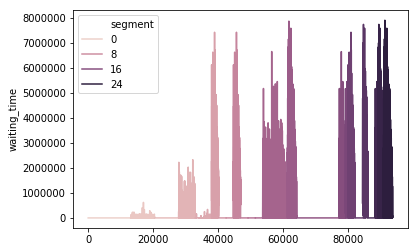

In [75]:
segment_df = get_segment_statistics_complete(df, segment_dict,dfg_activities_unique)
temp = segment_df.reset_index()
sns.lineplot( data=temp, x = temp.index,  y="waiting_time", hue="segment")
plt.show()

C:\Users\Shreya Kar\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecatedWarning: apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use algorithm entrypoint instead
  # Remove the CWD from sys.path while we load stuff.


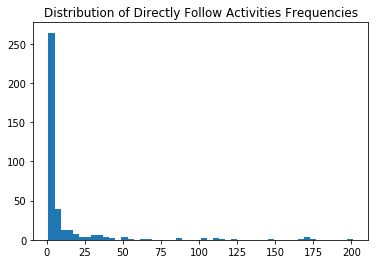

                          ta                  tb  segment  observations  \
Case ID                                                                   
Case 1   2012-01-02 01:00:00 2012-01-02 01:00:00      1.0           1.0   
Case 105 2012-01-03 07:00:00 2012-01-03 07:00:00      1.0           2.0   
Case 108 2012-01-05 12:14:00 2012-01-05 12:14:00      1.0           3.0   
Case 109 2012-01-12 07:27:00 2012-01-12 07:27:00      1.0           4.0   
Case 111 2012-01-15 08:16:00 2012-01-15 08:16:00      1.0           5.0   

          waiting_time  
Case ID                 
Case 1             0.0  
Case 105           0.0  
Case 108           0.0  
Case 109           0.0  
Case 111           0.0  


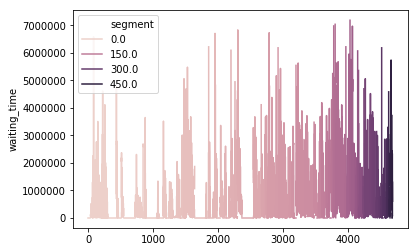

In [27]:
filename = 'prepared_data/Production_Data.csv'
df = load_event_log(filename)
df = df.fillna(method='ffill')
segment_dict,dfg_activities_unique = get_dfg_activities(df)
segment_df = get_segment_statistics(df, segment_dict,dfg_activities_unique)
temp = segment_df.reset_index()
sns.lineplot( data=temp, x = temp.index,  y="waiting_time", hue="segment")
plt.show()

C:\Users\Shreya Kar\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecatedWarning: apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use algorithm entrypoint instead
  # Remove the CWD from sys.path while we load stuff.


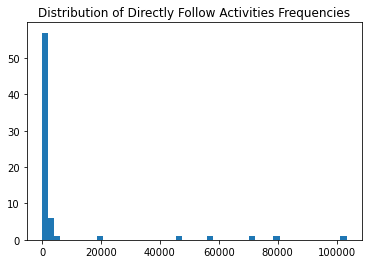

                         ta                  tb  segment  observations  \
Case ID                                                                  
A1      1999-12-31 23:00:00 2000-04-15 22:00:00        1             1   
A100    2000-01-01 23:00:00 2000-02-14 23:00:00        1             2   
A10000  2000-01-01 23:00:00 2000-02-14 23:00:00        1             3   
A10001  2000-01-01 23:00:00 2000-02-14 23:00:00        1             4   
A10004  2000-01-01 23:00:00 2000-02-14 23:00:00        1             5   

         waiting_time  
Case ID                
A1          9154800.0  
A100        3801600.0  
A10000      3801600.0  
A10001      3801600.0  
A10004      3801600.0  


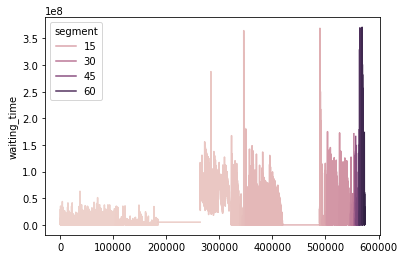

In [28]:
filename = 'prepared_data/traffic_fines.csv'
df = load_event_log(filename)
df = df.fillna(method='ffill')
segment_dict,dfg_activities_unique = get_dfg_activities(df)
segment_df = get_segment_statistics(df, segment_dict,dfg_activities_unique)
temp = segment_df.reset_index()
sns.lineplot( data=temp, x = temp.index,  y="waiting_time", hue="segment")
plt.show() 

# Forecast Next Activity Based on Performance Spectrum

C:\Users\Shreya Kar\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecatedWarning: apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use algorithm entrypoint instead
  # Remove the CWD from sys.path while we load stuff.


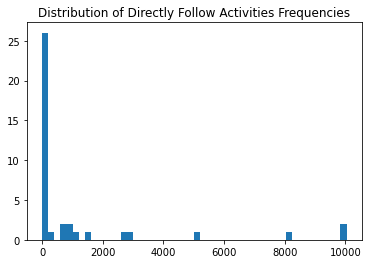

                                    ta                  tb  segment  \
Case ID                                                               
declaration 100000 2017-02-15 08:52:59 2018-01-08 15:36:03      1.0   
declaration 100005 2017-06-15 10:52:44 2018-06-12 07:30:32      1.0   
declaration 100010 2017-07-22 16:37:11 2018-01-09 07:54:33      1.0   
declaration 100015 2017-11-06 11:05:58 2018-01-17 09:47:40      1.0   
declaration 100021 2017-11-13 09:32:42 2018-05-07 07:34:36      1.0   

                    observations  waiting_time  
Case ID                                         
declaration 100000           1.0    28276984.0  
declaration 100005           2.0    31264668.0  
declaration 100010           3.0    14743042.0  
declaration 100015           4.0     6216102.0  
declaration 100021           5.0    15112914.0  


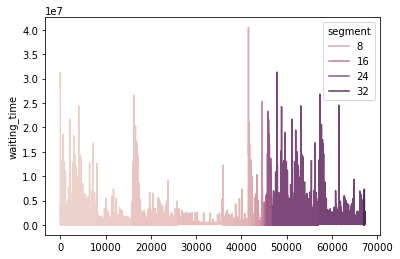

In [26]:
# read file and plot segment wise waiting time
filename = 'prepared_data/bpi20.csv'
df = load_event_log(filename)
df = df.fillna(method='ffill')
segment_dict,dfg_activities_unique = get_dfg_activities(df)
segment_df = get_segment_statistics(df, segment_dict,dfg_activities_unique)
temp = segment_df.reset_index()
sns.lineplot( data=temp, x = temp.index,  y="waiting_time", hue="segment")
plt.show()

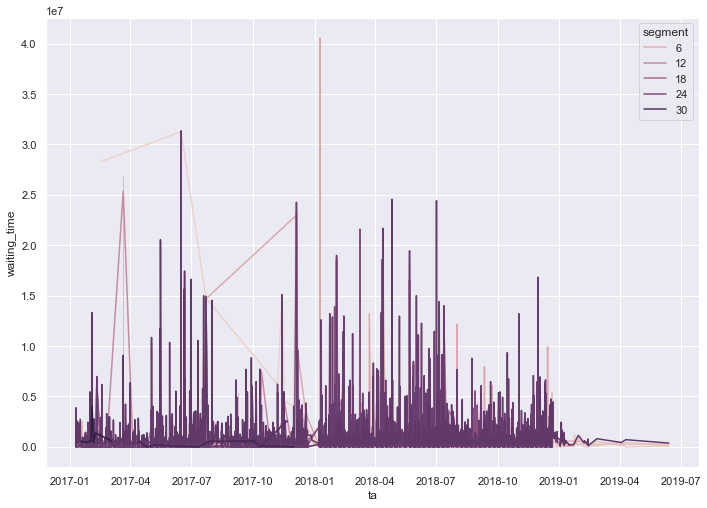

In [68]:
temp = segment_df[segment_df["segment"]==1.0]
temp.head()
#.reset_index()
sns.lineplot( data=segment_df[:-200], x = "ta",  y="waiting_time", hue="segment")
plt.show() 

In [28]:
seg_df = append_segment_to_log(df, segment_dict)
seg_df.head()

C:\Users\Shreya Kar\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,Resource,Activity,Start Timestamp,org:role,case:id,Case ID,case:BudgetNumber,case:DeclarationNumber,case:Amount,segment
12788,st_step 100004_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2018-01-30 08:20:07,EMPLOYEE,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,1
12789,st_step 100003_0,STAFF MEMBER,Declaration APPROVED by ADMINISTRATION,2018-02-07 08:58:46,ADMINISTRATION,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,2
12790,st_step 100002_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2018-02-08 09:59:05,SUPERVISOR,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,3
12791,dd_declaration 100000_19,SYSTEM,Request Payment,2018-02-09 11:42:49,UNDEFINED,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,4
12792,dd_declaration 100000_20,SYSTEM,Payment Handled,2018-02-12 16:31:20,UNDEFINED,declaration 100000,declaration 100000,budget 86566,declaration number 100001,600.844121,999


# Step 2: Functions for adding converting event log into feature vector

In [25]:
# helper functions for adding custom features
def calculate_workload(df,engaged_resources,case_start,event_end):
    """
     returns mean of total number of cases being worked on by an active resource involved for the caseID passed
    """
    res = []
    for resource in engaged_resources:
        res_cases = len(df[(df["Resource"]==resource)&(df["Start Timestamp"]>=case_start)&(df["Start Timestamp"]<=event_end)]["Case ID"].unique())
        res.append(res_cases)
    avg=sum(res)/len(res)
    return avg

def calculate_business_hours(st,et,weekends):
    #st = datetime.fromtimestamp(100000000)
    #et = datetime.fromtimestamp(200000000)
    bh_object = BusinessHours(st, et,weekends)
    print(bh_object.gethours())
    worked_time = bh_object.getseconds()
    print(worked_time)
    
#convert to sequences with ids
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
def create_transaction_encoding(values,keys):
    #activities = df["Activity"].unique()
    id_dict = dict()
    for key in keys:
        id_dict[key] = 0
    unique,counts = np.unique(values,return_counts=True)
    for key,val in zip(unique,counts):
        id_dict[key]=val
    return id_dict

def create_boolean_encoding(values,keys):
    id_dict = dict()
    for key in keys:
        id_dict[key] = False
    unique,counts = np.unique(values,return_counts=True)
    for key,val in zip(unique,counts):
        id_dict[key]= True if val>0 else False
    return id_dict

def create_sliding_windows(df,prefix_length,target):
    #dataframe = df.drop(columns=[target])
    dataframe = df
    #df = df.drop(columns=[target])
    for i in range(1,prefix_length):
        cols = {x: str(x)+"_"+str(i) for x in df.columns}
        d2= df.shift(i).rename(columns=cols)
        dataframe = pd.concat([dataframe,d2], axis=1)
    dataframe = dataframe.dropna()
    return dataframe

def find_case_finish_time(trace, num_activities):
    # we find the max finishtime for the actual case
    for i in range(num_activities):
        if i == 0:
            finishtime = trace[-i-1][-1]
        else:
            if trace[-i-1][-1] > finishtime:
                finishtime = trace[-i-1][-1]
    return finishtime
def calculate_remaining_time_for_actual_case(traces, num_activities):
    finishtime = find_case_finish_time(traces, num_activities)
    for i in range(num_activities):
        # calculate remaining time to finish the case for every activity in the actual case
        traces[-(i + 1)][-1] = (finishtime - traces[-(i + 1)][-1]).total_seconds()
    return traces

In [24]:
# def add_contextual_info(df, case_info, case_start, case_end, event_start, event_end, last_event_time,case):
#     #add information that pertains to the number of cases at a timepoint    
#     #number of cases that arrived after the start time of the case and before the end
#     #case_start = list(case_info[(case_info["Case ID"]==case)]["Start Timestamp"].values)[0]
#     #case_end = list(case_info[(case_info["Case ID"]==case)]["Complete Timestamp"].values)[0]
#     X=dict()
    
#     #ADD CASE RELATED INFORMATION
#     #number of cases that arrived since case start
#     X["cases_arrived"]= len(case_info[(case_info["Start Timestamp"]>=case_start) & (case_info["Start Timestamp"]<=event_end)]["Case ID"])
#     #number of cases that finished since case start
#     X["cases_finished"]= len(case_info[(case_info["Complete Timestamp"]>=case_start)&(case_info["Complete Timestamp"]<=event_end)]["Case ID"])
#     #number of cases that are not finished before case starts i.e. backlog of applications
#     X["cases_backlog"]= len(case_info[(case_info["Start Timestamp"]<=case_start)&(case_info["Complete Timestamp"]>=case_start)])                                      
    
#     #ADD RESOURCE AND WORKLOAD RELATED INFORMATION
#     X["number_of_resources_for_case"] = len(list(df[(df["Case ID"]==case)]["Resource"].unique()))
#     engaged_resources= df[(df["Start Timestamp"]>=case_start)&(df["Start Timestamp"]<=event_end)]["Resource"].unique()
#     total_resources = len(df["Resource"].unique())
#     X["free_resources"] = total_resources-len(engaged_resources)
#     X["avg_work_load"] = calculate_workload(df,engaged_resources,case_start,event_end)
#     #X["Resource_role"] = cluster_resource()
    
#     #environment information
#     #X["time_from_case_start"] = (event_start - case_start).total_seconds()
#     #X["time_from_last_event"] = (event_start - last_event_time).total_seconds()
#     X["Weekday"] = pd.to_datetime(case_start).weekday()
    
#     #add target column
#     X["remaining_time"] = (pd.to_datetime(case_end) - pd.to_datetime(event_end)).total_seconds()
    
#     #update time when last event happened
#     last_event_time = event_end
    
#     return last_event_time, X                           

In [25]:
# ## OLD freature creation function... DONOT RUN##
# def add_tracewise_features(enriched_df,case, prefix_length,case_info, mode):
#     """
#     returns a sliding window dataframe for this case    
#     """
#     case_start = list(case_info[(case_info["Case ID"]==case)]["Start Timestamp"].values)[0]
#     case_end = list(case_info[(case_info["Case ID"]==case)]["Complete Timestamp"].values)[0]
#     case_df = enriched_df[(enriched_df["Case ID"]==case)].reset_index(drop=True)
#     traces = []
#     context_info = []
#     last_event_time = list(case_df["Complete Timestamp"])[0]
#     for i,row in case_df.iterrows():
#         event_end = pd.to_datetime(row["Complete Timestamp"])
#         event_start = pd.to_datetime(row["Start Timestamp"])
#         last_event_time,X = add_contextual_info(enriched_df, case_info, case_start, case_end, event_start, event_end, last_event_time,case)
#         context_info.append(X)
#     #join enriched_df with contextual_info
#     context_df = pd.DataFrame.from_records(context_info)
#     dataframe = pd.concat([case_df,context_df],axis=1)
    
#     activities = []
#     resources = []
    
   
#     if mode=="aggregate":
#         activities = create_transaction_encoding(list(case_df["Activity"][:prefix_length]),enriched_df["Activity"].unique())
#         resources = create_transaction_encoding(list(case_df["Resource"][:prefix_length]),enriched_df["Resource"].unique())
#         #take last row values from dataframe
#         dataframe = dataframe.drop(columns=["Activity","Resource"],axis=1).loc[prefix_length-1,:]
#     else:
#          #generate sequences for gradient boosted tree i.e. sliding windows
#         target = "remaining_time"
#         target_column = pd.DataFrame(dataframe[target].shift(prefix_length-1)).reset_index()
#         dataframe = create_sliding_windows(dataframe,prefix_length,target)
#         dataframe = pd.concat([dataframe,target_column],axis=1)

    
#     return activities,resources,dataframe
# def prepare_feature_set(case,prefix_length, mode):
#     #aggregate start and complete times of each case ID which is needed for the feature generation
#     activities,resources,dataframe =add_tracewise_features(enriched_df,case, prefix_length,case_info,mode)
#     return activities,resources,dataframe

# data = pd.DataFrame()
# cases = list(enriched_df["Case ID"].unique())
# temp = enriched_df[["Case ID", "Start Timestamp", "Complete Timestamp"]]
# case_info = temp.groupby("Case ID").agg({"Start Timestamp": min, "Complete Timestamp":max}).reset_index() 
# activity_df = []
# resource_df = []
# # for case in cases[:200]:
# #     activities, resources, X = prepare_feature_set(case,3,mode="sequential")
# #     activity_df.append(activities) 
# #     resource_df.append(resources)
# #     data = data.append(X,ignore_index=True)
# #activity_df = pd.DataFrame.from_records(activity_df)
# #resource_df = pd.DataFrame.from_records(resource_df)
# #data = data.join(activity_df).join(resource_df)
# #data.head()

In [26]:
def calculateTimeFromMidnight(actual_datetime):
    midnight = actual_datetime.replace(hour=0, minute=0, second=0, microsecond=0)
    timesincemidnight = (actual_datetime - midnight).total_seconds()
    return timesincemidnight

def createActivityFeatures(line, caseID, case_info, case_start, case_end, event_start, event_end, lastevtime):

    activity = []
    for feature in line:
        activity.append(feature)
        
#     #ADD CASE RELATED INFORMATION
#     #number of cases that arrived since case start
#     activity.append(len(case_info[(case_info["Start Timestamp"]>=case_start) & (case_info["Start Timestamp"]<=event_end)]["Case ID"]))
#     #number of cases that finished since case start
#     activity.append(len(case_info[(case_info["Complete Timestamp"]>=case_start)&(case_info["Complete Timestamp"]<=event_end)]["Case ID"]))
#     #number of cases that are not finished before case starts i.e. backlog of applications
#     activity.append(len(case_info[(case_info["Start Timestamp"]<=case_start)&(case_info["Complete Timestamp"]>=case_start)]))                                      
    
    #ADD RESOURCE AND WORKLOAD RELATED INFORMATION
#     activity.append(len(list(df[(df["Case ID"]==caseID)]["Resource"].unique())))
#     engaged_resources= df[(df["Start Timestamp"]>=case_start)&(df["Start Timestamp"]<=event_end)]["Resource"].unique()
#     total_resources = len(df["Resource"].unique())
#     activity.append(total_resources-len(engaged_resources))
#     activity.append(calculate_workload(df,engaged_resources,case_start,event_end))
    #X["Resource_role"] = cluster_resource()

    
    #add features: time from trace start, time from last_startdate_event, time from midnight, weekday
    activity.append((event_start-case_start).total_seconds())
    activity.append((event_start -lastevtime).total_seconds())
    activity.append(calculateTimeFromMidnight(event_start))
    activity.append(event_start.weekday())
    # if there is also end_date add features time from event_duration
    activity.append((pd.to_datetime(event_end) - pd.to_datetime(event_start)).total_seconds())

    #add target column
    activity.append((pd.to_datetime(case_end) - pd.to_datetime(event_end)).total_seconds())
    
    return activity


In [27]:
#case_info, case_start, case_end, event_start, event_end, last_event_time
def add_features(df, case_info):
    dataset = df.values
    traces = []
    # make a dict of column positions
    col_names_dict = {c:i for i,c in enumerate(df.columns)}
    start_date_pos = col_names_dict.get("Start Timestamp")
    end_date_pos = col_names_dict.get("Complete Timestamp")
    
    # analyze first dataset line
    caseID = dataset[0][col_names_dict.get("Case ID")]
    activityTimestamp = pd.to_datetime(dataset[0][start_date_pos])
    case_end = list(case_info[(case_info["Case ID"]==caseID)]["Complete Timestamp"].values)[0]
    case_start = activityTimestamp
    event_start = activityTimestamp
    lastevtime = activityTimestamp
    event_end = dataset[0][end_date_pos]
    line = dataset[0] 
    activity = createActivityFeatures(line, caseID, case_info, case_start, case_end, event_start, event_end, lastevtime)
    traces.append(activity)

    for line in dataset[1:, :]:
        case = line[col_names_dict.get("Case ID")]
        if case == caseID:
            # continues the current case
            event_start = pd.to_datetime(line[start_date_pos])
            if end_date_pos is not None:
                event_end = pd.to_datetime(line[end_date_pos])
            activity = createActivityFeatures(line, caseID, case_info, case_start, case_end, event_start, event_end, lastevtime)

            # lasteventtimes become the actual
            lastevtime = event_start
            traces.append(activity)

        else:
            caseID = case
            activityTimestamp = pd.to_datetime(line[start_date_pos])
            case_end = list(case_info[(case_info["Case ID"]==caseID)]["Complete Timestamp"].values)[0]
            case_start = activityTimestamp
            event_start = activityTimestamp
            lastevtime = activityTimestamp
            event_end = line [end_date_pos]
            activity = createActivityFeatures(line, caseID, case_info, case_start, case_end, event_start, event_end, lastevtime)
            traces.append(activity)


    # construct df again with new features
    columns = df.columns
    print(columns)
    columns = list(columns)
#     "cases_arrived", "cases_finished", "cases_backlog", "number_of_resources_handling_case", "free_resources",
#                         "avg_resource_workload","number_of_resources_handling_case", "free_resources","avg_resource_workload", 
    if end_date_pos is not None:
        columns.extend(["time_from_start", "time_from_previous_event(start)", "time_from_midnight",
                        "weekday", "event_duration", "remaining_time"])
    df = pd.DataFrame(traces, columns=columns)
    del_cols = [start_date_pos, end_date_pos]
    df.drop(df.columns[del_cols],axis=1,inplace=True)
    print("Features added")
    return df

df["Complete Timestamp"] = df["Start Timestamp"]
df.head()

In [37]:
temp = df[["Case ID", "Start Timestamp", "Complete Timestamp"]]
case_info = temp.groupby("Case ID").agg({"Start Timestamp": min, "Complete Timestamp":max}).reset_index()
data = add_features(df,case_info)

Index(['id', 'Resource', 'Activity', 'Start Timestamp', 'org:role', 'case:id',
       'Case ID', 'case:BudgetNumber', 'case:DeclarationNumber', 'case:Amount',
       'Complete Timestamp'],
      dtype='object')
Features added


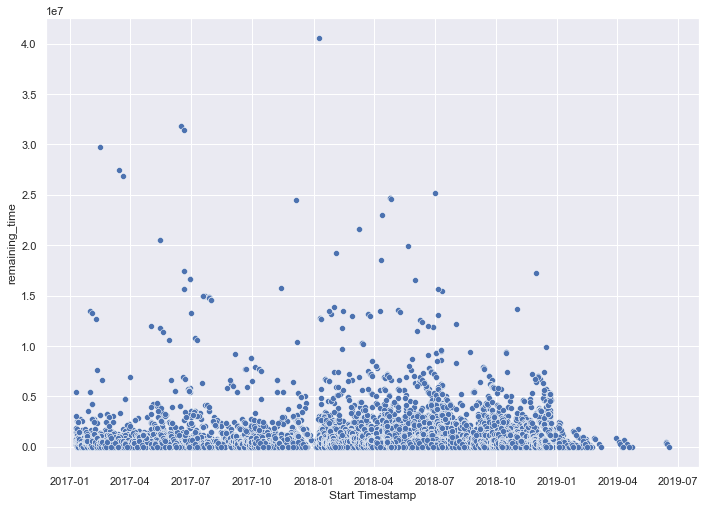

In [46]:
# event vs rtp
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot( data=data, x = "Start Timestamp",  y="remaining_time")
plt.show()

df_forecast = data[["Start Timestamp", "remaining_time"]]
df_forecast.rename(columns={"Start Timestamp": "ds", "remaining_time":"y"}, inplace=True)
df_forecast.head()
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.plot( data=df_forecast, x = "ds",  y="y")
plt.show()

from fbprophet import Prophet
# Python
m = Prophet()
m.fit(df_forecast[:15])

In [29]:
# add segment infomation to dataframe for joining with segment dataframe
def add_segment_info(df,segment_dict):
    activities = df.loc[:,"Activity"].values.astype('str')
    segment_list = []
    for a1,a2 in zip(activities[:-1], activities[1:]):
        #print(a1,a2)
        segment_list.append(segment_dict.get((a1,a2),0))
    #remove last column
    df_new = df[:-1]
    df_new["segment"] = segment_list
    return df_new

In [30]:
def concatenate_segment_df(segment_df,df_new):
    #reindex segment df
    segment_new = segment_df.set_index(["Case ID","ta", "segment"]).reindex(df_new.set_index(["Case ID", "Start Timestamp", "segment"]).index)
    segment_new = segment_new.fillna(method='ffill').reset_index()
    df_joined = pd.concat([df_new, segment_new], axis=1)
    df_joined = df_joined.loc[:,~df_joined.columns.duplicated()]
    return df_joined
# temp = segment_df.set_index(["Case ID","ta"])
# new_index = df.set_index(["Case ID", "Start Timestamp"]).index
# temp.reindex(new_index)

In [31]:
#enrich event log with temporal information about cycle time and partial lead time and convert to df
def enrich_event_log_df(df_joined):
    param_keys_enriched={constants.PARAMETER_CONSTANT_CASEID_KEY: 'Case ID',
        constants.PARAMETER_CONSTANT_RESOURCE_KEY: 'Resource', 
        constants.PARAMETER_CONSTANT_ACTIVITY_KEY: 'Activity',
        constants.PARAMETER_CONSTANT_START_TIMESTAMP_KEY: 'Start Timestamp',
        constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: 'Complete Timestamp',
        "business_hours": True,
        "weekends":[6,7]}
    log_new = log_conv.apply(df_joined, parameters=param_keys)
    enriched_log = interval_lifecycle.assign_lead_cycle_time(log_new, parameters=param_keys_enriched)
    enriched_df = log_converter.apply(enriched_log, variant=log_converter.Variants.TO_DATA_FRAME)
    enriched_df = enriched_df.drop(["case:concept:name"], axis=1)
    return enriched_df

In [ ]:
# temp = df[["Case ID", "Start Timestamp", "Complete Timestamp"]]
# case_info = temp.groupby("Case ID").agg({"Start Timestamp": min, "Complete Timestamp":max}).reset_index() 
# dataframe = add_features(enriched_df,case_info)

In [ ]:
# target = "remaining_time"
# prefix_length = 3
# data = create_sliding_windows(dataframe,prefix_length,target)
# data.head()

In [32]:
def return_segment_df(df,log, batch_delay):
    # filter dfg activities for important segments using thresholds
    dfg,threshold = return_dfg_activities(log)
    dfg_activities_unique = list(dfg.keys())
    #dfg_activities_unique = list(filter(lambda x:(x[0]!=x[1]) and (dfg.get(x)>16),dfg_activities))
    segment_dict = dict()
    i=1
    for val in dfg_activities_unique:
        segment_dict[val]=i
        i=i+1
    n = len(dfg_activities_unique)
    #fig, axs = plt.subplots(n,figsize=(50*n,10*n), sharex=True)
    axs="plt"
    i = 0
    df_list = []
    for a1,a2 in dfg_activities_unique:
        #print(a1,a2)
        segment= segment_dict.get((a1,a2))
        segment_data = plot_performance_spectrum(df,a1,a2,axs,i,"Resource",segment, batch_delay)
        if(not segment_data.empty):
            df_list.append(segment_data)
        i=i+1
    segment_df = pd.concat(df_list)
    #segment_df=df_list[0]
    return segment_df,segment_dict

In [33]:
#function to retrieve dataframe for event log
def return_dataframe(df,segment_df,segment_dict):
    
    #add segment info
    df_new = add_segment_info(df,segment_dict)
    # concatenate with segment df
    df_joined = concatenate_segment_df(segment_df,df_new)
    # calculate enriched log with temporal information
    enriched_df = enrich_event_log_df(df_joined)
    # encode event log as feature set suitable for prediction
    temp = df[["Case ID", "Start Timestamp", "Complete Timestamp"]]
    case_info = temp.groupby("Case ID").agg({"Start Timestamp": min, "Complete Timestamp":max}).reset_index() 
    dataframe = add_features(enriched_df,case_info)
    return dataframe

In [37]:
def prepare_data_for_prediction(file_name, batch_delay):
    df = read_file(file_name)
#     if("Complete Timestmap" not in df.columns):
#         df["Complete Timestamp"] = df["Start Timestamp"]
    df = preprocess_df(df)
    #sort df
    df = sort_df(df)
    #fill missing values
    df.fillna(0, inplace=True)
    print("Read and preprocessed Event Log.....")
    print(df.head())
    print("Converting to Feature Set....")
    log = convert_df_to_log(df)
    segment_df, segment_dict = return_segment_df(df,log, batch_delay)
    dataframe = return_dataframe(df,segment_df,segment_dict)
    return dataframe   

# Step 3:Derive Advanced Features

# Step 3.1. use a decisision tree to learn decision points

In [ ]:
def find_weekday(case):
    filter_df = case_info[(case_info["Case ID"]==case)]
    weekday = pd.to_datetime(filter_df.iloc[0,0]).weekday()
    return weekday

In [ ]:
param_keys={constants.PARAMETER_CONSTANT_CASEID_KEY: 'Case ID',
    constants.PARAMETER_CONSTANT_RESOURCE_KEY: 'Resource', 
    constants.PARAMETER_CONSTANT_ACTIVITY_KEY: 'Activity',
    constants.PARAMETER_CONSTANT_ATTRIBUTE_KEY: 'AMOUNT_REQ',       
    constants.PARAMETER_CONSTANT_START_TIMESTAMP_KEY: 'Start Timestamp',
    constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: 'Complete Timestamp'}
df1=df
df1["Resource"]=df1["Resource"].apply(str)
df1["Weekday"] = df1["Case ID"].apply(lambda x: find_weekday(x))
log1 = log_conv.apply(df1, parameters=param_keys)
log1 = log_conversion.apply(log1, parameters=param_keys)

In [ ]:
st_times = case_info.iloc[:,0]
et_times = case_info.iloc[:,1]
case_durations = []
for st,end in zip(st_times,et_times):
    case_duration = (pd.to_datetime(end)-pd.to_datetime(st)).total_seconds()
    case_durations.append(case_duration)
median_case_duration = np.median(case_durations)
target = list(map(lambda x: 0 if (x<=median_case_duration) else 1, case_durations))
classes = ["LESSEQ", "GREATER"]

--returning wrong values when using pm4pmy func
from pm4py.statistics.traces.log import case_statistics
param_keys={constants.PARAMETER_CONSTANT_CASEID_KEY: 'Case ID',
    constants.PARAMETER_CONSTANT_RESOURCE_KEY: 'Resource', 
    constants.PARAMETER_CONSTANT_ACTIVITY_KEY: 'Activity',
    constants.PARAMETER_CONSTANT_ATTRIBUTE_KEY: 'AMOUNT_REQ',       
    constants.PARAMETER_CONSTANT_START_TIMESTAMP_KEY: 'Start Timestamp',
    constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: 'Complete Timestamp',
            case_statistics.Parameters.TIMESTAMP_KEY: 'Start Timestamp',
            case_statistics.Parameters.TIMESTAMP_KEY: 'Complete Timestamp'
           }
median_case_duration = case_statistics.get_median_caseduration(log1, parameters=param_keys)
case_durations = case_statistics.get_all_casedurations(log1, parameters=param_keys)
median_case_duration
case_durations

In [ ]:
from pm4py.objects.log.util import get_log_representation
data, feature_names = get_log_representation.get_representation(log1,str_ev_attr=["Activity", "Resource"],str_tr_attr=["Weekday"], num_ev_attr=["AMOUNT_REQ"], num_tr_attr=[])
#data, feature_names = get_log_representation.get_default_representation(log, parameters=param_keys_f)
feature_df= pd.DataFrame(data, columns=feature_names)
#threshold case duration

#from pm4py.objects.log.util import get_class_representation
#target, classes = get_class_representation.get_class_representation_by_trace_duration(log1,median_case_duration,timestamp_key="Start Timestamp", parameters=param_keys)

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit(data, target)

from pm4py.visualization.decisiontree import visualizer as dectree_visualizer
gviz = dectree_visualizer.apply(clf, feature_names, classes)

In [ ]:
gviz

#exploring pm4py
from pm4py.util import xes_constants as xes
from pm4py.statistics.traces.pandas import case_statistics
from pm4py.statistics.variants.log import get as variants_filter
resource_key = exec_utils.get_param_value(Parameters.RESOURCE_KEY, param_keys, xes.DEFAULT_RESOURCE_KEY)

parameters_variants = {case_statistics.Parameters.ACTIVITY_KEY: resource_key,
                       case_statistics.Parameters.ATTRIBUTE_KEY: resource_key}
variants_occ = {x: len(y) for x, y in variants_filter.get_variants(log1, parameters=parameters_variants).items()}
variants_resources = list(variants_occ.keys())
variants_occ

# Step 3.2. Clustering Resources

In [ ]:
#kmeans clustering --helper function
from sklearn.cluster import KMeans
def cluster_traces_kmeans(X,n):
    clustering = KMeans(n_clusters=n, random_state=0).fit(X)
    return clustering.labels_

In [ ]:
#dbscan clustering --helper function
from sklearn.cluster import DBSCAN
def cluster_traces_DBSCAN(X):
    clustering = DBSCAN(eps=0.5, min_samples = 2).fit(X)
    return clustering.labels_

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
def cluster_traces_linkage(X,n):
    Z = linkage(X, 'ward')
    labels = cut_tree(Z, n_clusters=n)
    labels = [item for sublist in labels for item in sublist]
    return labels

In [ ]:
#calculate case arrival/dispersion rate for trace taken from pm4py mostly
def calculate_case_arrival_rate(resources):
    timest_key = "Start Timestamp"
    arrival_rates = []
    for resource in resources:        
        first = df[df["Resource"]==resource].groupby("Case ID").first()
        first_df = first.sort_values(timest_key)
        first_df_shift = first_df.shift(-1)
        first_df_shift.columns = [str(col) + '_2' for col in first_df_shift.columns]

        df_successive_rows = pd.concat([first_df, first_df_shift], axis=1)
        df_successive_rows['interlapsed_time'] = (
                df_successive_rows[timest_key + '_2'] - df_successive_rows[timest_key]).astype('timedelta64[s]')

        df_successive_rows = df_successive_rows.dropna(subset=['interlapsed_time'])
        arrival_rates.append(df_successive_rows['interlapsed_time'].mean())

    case_arrival_df = pd.DataFrame({"case_arrival":arrival_rates})
    return case_arrival_df    

In [ ]:
#calculate case arrival/dispersion rate for trace taken from pm4py mostly
def calculate_case_dispersal_rate(resources):
    timest_key = "Complete Timestamp"
    dispersal_rates = []
    for resource in resources:        
        first = df[df["Resource"]==resource].groupby("Case ID").last()
        first_df = first.sort_values(timest_key)
        first_df_shift = first_df.shift(-1)
        first_df_shift.columns = [str(col) + '_2' for col in first_df_shift.columns]

        df_successive_rows = pd.concat([first_df, first_df_shift], axis=1)
        df_successive_rows['interlapsed_time'] = (
                df_successive_rows[timest_key + '_2'] - df_successive_rows[timest_key]).astype('timedelta64[s]')

        df_successive_rows = df_successive_rows.dropna(subset=['interlapsed_time'])
        dispersal_rates.append(df_successive_rows['interlapsed_time'].mean())

    case_dispersal_df = pd.DataFrame({"case_dispersal":dispersal_rates})
    return case_dispersal_df 

In [ ]:
#function to create traces of activities performed by resources
def create_activity_frequency_vector(resource, activityList):
    column_names=list(df["Activity"].unique())
    #column_names=["Resource"]+column_names
    X=pd.DataFrame(columns=column_names)
    activities,counts = np.unique(np.array(activityList),return_counts=True)
    freq_dict = dict()
    for a,val in zip(activities,counts):
        freq_dict[a]=val
    for col in column_names[:]:
        X.loc[0,col] = freq_dict.get(col,0)
    return X

In [ ]:
# create feature vector for resources based on activities performed
def cluster_traces_resources():
    resources = df["Resource"].unique()
    res_activity_vector = pd.DataFrame()
    for res in resources:
        activityList=list(df[df["Resource"]==res]["Activity"])
        X=create_activity_frequency_vector(res,activityList)
        res_activity_vector=res_activity_vector.append(X,ignore_index=True)
    return res_activity_vector

In [ ]:
# create feature vector for cases based on activities performed
def cluster_traces_cases():
    cases = df["Case ID"].unique()
    case_activity_vector = pd.DataFrame()
    for case in cases:
        activityList=list(df[df["Case ID"]==case]["Activity"])
        X=create_activity_frequency_vector(case,activityList)
        case_activity_vector=case_activity_vector.append(X,ignore_index=True)
    return case_activity_vector

In [ ]:
# to differential between behavior of a resource
#sequential: case arrival rate should be high and case dispersal rate should be high too
#batch: case arrival rate is low and case dispersal should be low too..
# high case arrival rate and low case dispersal or vice-versa?

In [ ]:
def normalize_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df.iloc[:, :].values)
    columns = [x for x in df.columns]
    df = pd.DataFrame(scaled, columns=columns)
    return df

In [ ]:
resources = df["Resource"].unique()
case_arrival_df = calculate_case_arrival_rate(resources)
case_dispersal_df = calculate_case_dispersal_rate(resources)
#use fillna for resources that only worked on one case
case_arrival_dispersal_df = pd.concat([case_arrival_df,case_dispersal_df], axis = 1).fillna(1)
case_arrival_dispersal_df = normalize_data(case_arrival_dispersal_df)
case_arrival_dispersal_df.head()

In [ ]:
#cluster them into categories Sequential or Batch
X=np.array(case_arrival_dispersal_df)
n=2
labels = cluster_traces_kmeans(X,n)
labels = list(map(lambda x: "batch" if x==0 else "sequential", labels))
clustering_df=pd.DataFrame({"x":case_arrival_dispersal_df["case_arrival"], "y":case_arrival_dispersal_df["case_dispersal"],"cluster":labels})
import seaborn as sns
sns.scatterplot(data=clustering_df,x="x", y="y",hue="cluster")
plt.xlabel("case_arrival_frequency")
plt.ylabel("case_dispersal_frequency")
plt.title("Cluster Resources Based on Behaviour at Process Level")
plt.savefig("data/res_behaviour_cluster.png",dpi=1200)

In [ ]:
# define labels based on figure and add them to resource dataframe
behavior_labels = list(map(lambda x: "Batch" if x==0 else "Sequential",labels))
dataframe1 = cluster_traces_resources()
dataframe2 = pd.DataFrame({"behavior":behavior_labels})
resource_behavior_df = pd.concat([dataframe1,dataframe2], axis=1)
resource_behavior_df.head()

In [ ]:
#apply tsne clustering to visualise high dimensional data to cluster resources based on activities and behavior
from sklearn.manifold import TSNE
tsne = TSNE( learning_rate = 50)
X = resource_behavior_df.iloc[:,:-1]
tsne_features = tsne.fit_transform(X)

In [ ]:
# Visualise clusters to chose an appropriate k
labels = cluster_traces_kmeans(X,3)
clustering_df = pd.DataFrame({'x':tsne_features[:,0],'y':tsne_features[:,1],'cluster':np.array(labels),'behavior':resource_behavior_df.iloc[:,-1]})
clustering_df["cluster"] = clustering_df["cluster"].apply(lambda x: "Cluster_"+str(x))
import seaborn as sns
sns.scatterplot(data=clustering_df,x="x", y="y", hue="cluster")
plt.title("Clustering Resources Based on Similar Activities")
plt.savefig("data/res_activity_cluster.png",dpi=1200)

In [ ]:
#cluster cases based on a activities
dataframe1 = cluster_traces_cases()
dataframe1.head()

In [ ]:
#apply tsne clustering to visualise high dimensional data to cluster resources based on activities and behavior
from sklearn.manifold import TSNE
tsne = TSNE( learning_rate = 50)
X = dataframe1
tsne_features = tsne.fit_transform(X)

In [ ]:
# Visualise clusters to chose an appropriate k
labels = cluster_traces_kmeans(X,10)
clustering_df = pd.DataFrame({'x':tsne_features[:,0],'y':tsne_features[:,1],'cluster':np.array(labels)})
clustering_df["cluster"] = clustering_df["cluster"].apply(lambda x: "Cluster_"+str(x))
import seaborn as sns
sns.scatterplot(data=clustering_df,x="x", y="y", hue="cluster")
plt.title("Clustering Cases Based on Similar Activities")
plt.savefig("data/cases_activity_cluster.png",dpi=1200)

In [ ]:
# Visualise clusters to chose an appropriate n for linkage method
labels = cluster_traces_linkage(X,4)
clustering_df = pd.DataFrame({'x':tsne_features[:,0],'y':tsne_features[:,1],'z':np.array(labels),'behavior':resource_behavior_df.iloc[:,-1]})
clustering_df["cluster"] = clustering_df["z"].apply(lambda x: "Cluster_"+str(x))
import seaborn as sns
sns.scatterplot(data=clustering_df,x="x", y="y", hue="z")

#conclusion: k=4 or k=5

In [ ]:
# cross check results with sna analysis
#discover roles based on work together
from pm4py.algo.enhancement.sna import algorithm as sna
path_save_base = os.path.abspath('./')
log = log_conv.apply(df1, parameters=param_keys)
wt_values = sna.apply(log, parameters=param_keys,variant=sna.Variants.JOINTACTIVITIES_LOG)
from pm4py.visualization.sna import factory as sna_vis_factory
gviz_hw_py = sna_vis_factory.apply(wt_values, variant="pyvis")
sna_vis_factory.save(gviz_hw_py, os.path.join(path_save_base, 'sna_joint activities.html'), variant="pyvis")
distance_matrix=wt_values[0]

In [ ]:
#reapeat clustering with this metric
# Visualise clusters to chose an appropriate n for linkage method
#apply tsne clustering to visualise high dimensional data to cluster resources based on activities and behavior
from sklearn.manifold import TSNE
tsne = TSNE( learning_rate = 50)
X = distance_matrix
tsne_features = tsne.fit_transform(X)
#labels = cluster_traces_linkage(X,4)
labels = cluster_traces_kmeans(X,3)
clustering_df = pd.DataFrame({'x':tsne_features[:,0],'y':tsne_features[:,1],'z':np.array(labels),'behavior':resource_behavior_df.iloc[:,-1]})
clustering_df["cluster"] = clustering_df["z"].apply(lambda x: "Cluster_"+str(x))
import seaborn as sns
sns.scatterplot(data=clustering_df,x="x", y="y", hue="z")

# Step 4: Implement DT

# LGB Model

In [ ]:
#remove all rows where remaining time is 0 if mode==aggregate
#drop_indices = data[(data["remaining_time"==0.0])].index
#print(drop_indices)
#data = data.drop(drop_indices)
#split in test and train
# i=2
# data = data.dropna()
# data = data.drop(columns=["index"])
# X=data.drop(columns=["remaining_time"],axis=1)
# X_train = X[X.columns][:-10]
# Y_train = data["remaining_time"][:-10]
# X_test = X[X.columns][-10:]
# Y_test = data["remaining_time"][-10:]

In [ ]:
# # mode =="aggregate"
# date_time_columns = [cname for cname in X.columns if 
#                                 X[cname].dtype == "datetime64[ns]"]
# #also drop CASE ID
# case_id_cols = ["Case ID", "Case ID_1", "Case ID_2"]
# for id_case in case_id_cols:
#     date_time_columns.append(id_case)
# X_test = X_test.drop(date_time_columns,axis=1)
# X_train = X_train.drop(date_time_columns,axis=1)
# categorical_cols = ["Weekday"]
# for feature in categorical_cols:
#     X_train[feature] = X_train[feature].astype('category')
#     X_test[feature] = X_test[feature].astype('category')

In [34]:
def train_model_1(X_train,Y_train,X_test,Y_test,categorical_cols):
    params = {
        "colsample_bytree": 0.5,
               "learning_rate": 0.05,
               "max_depth": 6,
               "n_clusters": 1,
               "n_estimators": 250,
               "subsample": 0.8,

#         'nthread': 10,
#          'max_depth': 5,
#     #         'max_depth': 9,
#         'task': 'train',
#         'boosting_type': 'gbdt',
        'objective': 'regression_l1',
        'metric': 'mape' # this is abs(a-e)/max(1,a)
#     #         'num_leaves': 39,
#         'num_leaves': 64,
#         'learning_rate': 0.2,
#        'feature_fraction': 0.9,
#     #         'feature_fraction': 0.8108472661400657,
#     #         'bagging_fraction': 0.9837558288375402,
#        'bagging_fraction': 0.8,
#         'bagging_freq': 5,
#         'lambda_l1': 3.097758978478437,
#         'lambda_l2': 2.9482537987198496,
#     #       'lambda_l1': 0.06,
#     #       'lambda_l2': 0.1,
#         'verbose': 0,
#         'min_child_weight': 6.996211413900573,
#         'min_split_gain': 0.037310344962162616,
        }

    lgb_train = lgb.Dataset(X_train,Y_train,categorical_feature= categorical_cols)
    lgb_valid = lgb.Dataset(X_test,Y_test,categorical_feature = categorical_cols)
    model = lgb.train(params, lgb_train, 3000, valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=100, verbose_eval=50)
    y_pred =model.predict(X_test)
    mae_seconds = metrics.mean_absolute_error(np.array(Y_test), y_pred)
    mae_days = mae_seconds/(3600*24)
    return mae_days,y_pred,model

In [ ]:
# thresholds = sorted(model.feature_importances_)
# thresholds = list(filter(lambda x: x>10, thresholds))
# from sklearn.feature_selection import SelectFromModel
# for thresh in thresholds:
# # select features using threshold
#     selection = SelectFromModel(model, threshold=thresh, prefit=True)
#     select_X_train = selection.transform(X_train)
#     # train model
#     selection_model = lgb.LGBMRegressor(loss_function= 'mean_squared_error', custom_metric=['Accuracy','AUC'],eval_metric='F1')
#     selection_model.fit(select_X_train, Y_train, feature_name='auto', categorical_feature = 'auto', verbose=50)
#     # eval model
#     select_X_test = selection.transform(X_test)
#     predictions = selection_model.predict(select_X_test)
#     print(metrics.mean_absolute_error(np.array(Y_test), predictions))

In [35]:
#remove all rows where remaining time is 0
def split_test_train_data(data, prefix_length,target,split_index):
    i=prefix_length-1
    #+"_"+str(i)
    drop_indices = data[data[target]==0.0].index
    data = data.drop(drop_indices)
    if(not data.empty):
        #split in test and train
        X=data.drop(columns=[target],axis=1)
        X_train = X[X.columns][:-split_index]
        Y_train = data[target][:-split_index]
        X_test = X[X.columns][-split_index:]
        Y_test = data[target][-split_index:]
    else:
        X=''
        X_train = ''
        Y_train = ''
        X_test = ''
        Y_test = ''
    return X,X_train,Y_train,X_test,Y_test

In [36]:
def preprocess_test_train_data(X,X_train,Y_train,X_test,Y_test, prefix_length,target):
    # returns preprocessed dataframe suitable for training model
    
    # drop all time stamp columns
    date_time_columns = [cname for cname in X.columns if 
                                    X[cname].dtype == "datetime64[ns]"]
    case_id_cols = ["Case ID"]
    for i in range(1,prefix_length):
        case_id_cols.append("Case ID_"+str(i))
    for id_case in case_id_cols:
        date_time_columns.append(id_case)
        
    
    X_test = X_test.drop(date_time_columns,axis=1)
    X_train = X_train.drop(date_time_columns,axis=1)
    
    #convert all categorical varibales to dtype category for lightgbm
    cols_max=["Activity","Resource", "weekday"]
    cols_seg = ["is_batch", "batch", "segment"]
    all_cols=[]
    all_cols.append(cols_max)
    for i in range(1,prefix_length):
        cols_new = list(map(lambda x:x+"_"+str(i),cols_max))
        all_cols.append(cols_new)
    #flatten list
    categorical_cols = [item for sublist in all_cols for item in sublist ]
    if target in cols_seg:
        if target in X.columns:
            categorical_cols.append(target)
    for feature in categorical_cols:
        if feature in X_train.columns:
            X_train[feature] = X_train[feature].astype('category')
            X_test[feature] = X_test[feature].astype('category')
    return X_train,Y_train,X_test,Y_test,categorical_cols

In [37]:
# fit a lightGBM model to the data
def train_model(X_train,Y_train,X_test,Y_test):
    model = lgb.LGBMRegressor(loss_function= 'mean_squared_error', custom_metric=['Accuracy','AUC'],eval_metric='F1')
    model.fit(X_train, Y_train, eval_set=(X_test, Y_test), feature_name='auto', categorical_feature = 'auto', verbose=50)
    #model_elapse = time() - start
    #print('elapse:, ', model_elapse)
    print(); print(model)
    # make predictions
    expected_y  = Y_test
    y_pred = model.predict(X_test)
    expected_y, y_pred
    mae_seconds = metrics.mean_absolute_error(np.array(Y_test), y_pred)
    mae_days = mae_seconds/(24*3600)
    feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
    feat_imp.nlargest(30).plot(kind='barh')
    plt.title("feature importance")
    plt.show()
    return mae_days,y_pred,model

In [38]:
# Train model for measuring weighted average for each prefix
mae_days=[]
for i in range(2,5):
    target = "remaining_time"
    prefix_length = i
    print(i)
    data = create_sliding_windows(dataframe,prefix_length,target)
    X,X_train,Y_train,X_test,Y_test = split_test_train_data(data, prefix_length,target)
    cat_cols = ["Activity","Resource", "weekday", "is_batch", "batch", "segment"]
    X_train,Y_train,X_test,Y_test,categorical_cols = preprocess_test_train_data(X,X_train,Y_train,X_test,Y_test, prefix_length, cat_cols)
    mae,y_pred = train_model(X_train,Y_train,X_test,Y_test)
    mae_days.append(mae)
print(mae_days)

2


NameError: name 'dataframe' is not defined

In [ ]:
#predict next segment and its statistics
file_name = "data/bpi12a"
dataframe = prepare_data_for_prediction(file_name, batch_delay = '1H')
max_prefix_length = np.max(dataframe.groupby("Case ID")["Activity"].count().values)
if max_prefix_length>20:
    max_prefix_length = 20
mae_days = []
weights_p = []
for prefix_length in range(2,max_prefix_length):
    #prefix_length = 3
    features_to_predict = ["segment","is_batch","batch", "m", "mean_BI", "mean_k", "observations",
            "std_k","tb_seconds", "waiting_time", "remaining_time"]
    cols_to_include = list(set(dataframe.columns)-set(features_to_predict))
    print(cols_to_include)
    i=0
    for feature in features_to_predict:
        #replace predicted values
        cols_to_include.append(feature)
        dataframe_mod = dataframe[cols_to_include]
        data = create_sliding_windows(dataframe_mod,prefix_length,target)
        split_index = int(0.20*data.shape[0])
        print(split_index)
        if(i>0):
            j=0
            for i,row in data[-10:].iterrows():
                row["target"]=preds[j]
                j=j+1
        target = feature    
        cols_included = cols_to_include[:-1]
        X,X_train,Y_train,X_test,Y_test = split_test_train_data(data, prefix_length,target,split_index)
        X_train,Y_train,X_test,Y_test,categorical_cols = preprocess_test_train_data(X,X_train,Y_train,X_test,Y_test, prefix_length,cols_included)
        mae_day, y_pred, model = train_model_1(X_train,Y_train,X_test,Y_test,categorical_cols)
        #preds = data.values
        preds = np.array(y_pred)
        i=i+1
    mae_days.append(mae_day)
    weights_p.append(prefix_length)
w_mae = np.average(mae_days,weights=weights_p)
print("weighted_mae_days:",w_mae)    

In [ ]:
import math
# w_mae_mean = np.average(mae_days,weights=weights_p)
# variance = np.average((mae_days-w_mae_mean)**2, weights=weights_p)
# print(w_mae_mean, math.sqrt(variance))

In [ ]:
a = np.array([1,2])
b = np.array([2,3])
np.concate((a,b))

In [ ]:
# create task for Logistic Regression
from sklearn.linear_model import LogisticRegression
features_to_predict = ["is_batch","batch", "m", "mean_BI", "mean_k", "observations",
        "std_k","tb_seconds", "waiting_time", "remaining_time"]
cols_to_include = list(set(dataframe.columns)-set(features_to_predict))
print(cols_to_include)
target = "segment"
dataframe_mod = dataframe[cols_to_include]
data = create_sliding_windows(dataframe_mod,prefix_length,feature)
X,X_train,Y_train,X_test,Y_test = split_test_train_data(data, prefix_length,target,split_index)
X_train,Y_train,X_test,Y_test,categorical_cols = preprocess_test_train_data(X,X_train,Y_train,X_test,Y_test, prefix_length,cols_included)
mae_day, y_pred, model = train_model_1(X_train,Y_train,X_test,Y_test,categorical_cols)

In [ ]:
# model for prefix length =4 and log=bpi2012
#predict next segment and its statistics
# file_name = "data/bpi12a"
# dataframe = prepare_data_for_prediction(file_name, batch_delay = '1H')
prefix_length = 4
features_to_predict = ["segment","is_batch","batch", "m", "mean_BI", "mean_k", "observations",
        "std_k","tb_seconds", "waiting_time", "remaining_time"]
cols_to_include = list(set(dataframe.columns)-set(features_to_predict))
i=0
temp = dataframe
targets = []
preds= []
dataframe_mod = temp[cols_to_include]
data = create_sliding_windows(dataframe_mod,prefix_length,feature)
for feature in features_to_predict:
    #replace predicted values
    cols_to_include.append(feature)
    split_index = int(0.20*data.shape[0])
    split_index=10
    #print(split_index)
    if(i>0):
        j=0
        for i,row in data[-split_index:].iterrows():
            row.loc[i,target]=y_pred[j]
            j=j+1
    #append to data
    new_df = pd.DataFrame({feature:dataframe[feature][(prefix_length-1):]}, index=data.index)
    data = pd.concat([data,new_df],axis=1)
    #targets.append(feature)
    target = feature    
    cols_included = cols_to_include[:-1]
    X,X_train,Y_train,X_test,Y_test = split_test_train_data(data,prefix_length,target,split_index)
    if(type(X) == str):
        y_pred = np.repeat(0,data[-split_index:].shape[0])
    else:
        print(data.head())
        X,X_train,Y_train,X_test,Y_test = split_test_train_data(data, prefix_length,target,split_index)
        X_train,Y_train,X_test,Y_test,categorical_cols = preprocess_test_train_data(X,X_train,Y_train,X_test,Y_test, prefix_length,target)
        mae_day, y_pred, model = train_model_1(X_train,Y_train,X_test,Y_test,categorical_cols)
        #preds = data.values
        preds.append(y_pred)
    i=i+1
# plt.xlabel('y_true')
# plt.ylabel('y_predicted')
# plt.scatter(Y_test,y_pred)
# plt.savefig("data/res_1.png",dpi=1200)
print(mae_day)

In [ ]:
file_name = "data/bpi12w"
dataframe = prepare_data_for_prediction(file_name, batch_delay = '1H')
max_prefix_length = np.max(dataframe.groupby("Case ID")["Activity"].count().values)
#predict next segment and its statistics
if max_prefix_length>20:
    max_prefix_length = 20
mae_days = []
weights_p = []
for prefix_length in range(2,max_prefix_length):
    #prefix_length = 3
    features_to_predict = ["segment","is_batch","batch", "m", "mean_BI", "mean_k", "observations",
            "std_k","tb_seconds", "waiting_time", "remaining_time"]
    cols_to_include = list(set(dataframe.columns)-set(features_to_predict))
    print(cols_to_include)
    i=0
    for feature in features_to_predict:
        #replace predicted values
        cols_to_include.append(feature)
        dataframe_mod = dataframe[cols_to_include]
        data = create_sliding_windows(dataframe_mod,prefix_length,feature)
        split_index = int(0.20*data.shape[0])
        print(split_index)
        if(i>0):
            j=0
            for i,row in data[-split_index:].iterrows():
                row["target"]=preds[j]
                j=j+1
        target = feature    
        cols_included = cols_to_include[:-1]
        X,X_train,Y_train,X_test,Y_test = split_test_train_data(data, prefix_length,target,split_index)
        if(type(X) == str):
            preds = np.repeat(0,data[-split_index:].shape[0])
        else:
            X,X_train,Y_train,X_test,Y_test = split_test_train_data(data, prefix_length,target,split_index)
            X_train,Y_train,X_test,Y_test,categorical_cols = preprocess_test_train_data(X,X_train,Y_train,X_test,Y_test, prefix_length,cols_included)
            mae_day, y_pred, model = train_model_1(X_train,Y_train,X_test,Y_test,categorical_cols)
            #preds = data.values
            preds = np.array(y_pred)
        i=i+1
    mae_days.append(mae_day)
    weights_p.append(prefix_length)
w_mae = np.average(mae_days,weights=weights_p)
w_mae_mean = np.average(mae_days,weights=weights_p)
variance = np.average((mae_days-w_mae_mean)**2, weights=weights_p)
print(w_mae_mean, math.sqrt(variance))

In [ ]:
import math
w_mae = np.average(mae_days,weights=weights_p)
w_mae_mean = np.average(mae_days,weights=weights_p)
variance = np.average((mae_days-w_mae_mean)**2, weights=weights_p)
print(w_mae_mean, math.sqrt(variance))

In [ ]:
plt.scatter(Y_test,y_pred)

In [ ]:
file_name = "data/bpi12o"
dataframe = prepare_data_for_prediction(file_name, batch_delay = '1H')
max_prefix_length = np.max(dataframe.groupby("Case ID")["Activity"].count().values)
#predict next segment and its statistics
if max_prefix_length>20:
    max_prefix_length = 20
print(max_prefix_length)
mae_days = []
weights_p = []
for prefix_length in range(2,max_prefix_length):
    print(prefix_length)
    #prefix_length = 3
    features_to_predict = ["segment","is_batch","batch", "m", "mean_BI", "mean_k", "observations",
            "std_k","tb_seconds", "waiting_time", "remaining_time"]
    cols_to_include = list(set(dataframe.columns)-set(features_to_predict))
    print(cols_to_include)
    i=0
    for feature in features_to_predict:
        #replace predicted values
        cols_to_include.append(feature)
        dataframe_mod = dataframe[cols_to_include]
        data = create_sliding_windows(dataframe_mod,prefix_length,feature)
        split_index = int(0.20*data.shape[0])
        print(split_index)
        if(i>0):
            j=0
            for i,row in data[-split_index:].iterrows():
                row["target"]=preds[j]
                j=j+1
        target = feature    
        cols_included = cols_to_include[:-1]
        X,X_train,Y_train,X_test,Y_test = split_test_train_data(data, prefix_length,target,split_index)
        if(type(X) == str):
            preds = np.repeat(0,data[-split_index:].shape[0])
        else:
            X,X_train,Y_train,X_test,Y_test = split_test_train_data(data, prefix_length,target,split_index)
            X_train,Y_train,X_test,Y_test,categorical_cols = preprocess_test_train_data(X,X_train,Y_train,X_test,Y_test, prefix_length,cols_included)
            mae_day, y_pred, model = train_model_1(X_train,Y_train,X_test,Y_test,categorical_cols)
            #preds = data.values
            preds = np.array(y_pred)
        i=i+1
    mae_days.append(mae_day)
    weights_p.append(prefix_length)
w_mae = np.average(mae_days,weights=weights_p)
w_mae_mean = np.average(mae_days,weights=weights_p)
variance = np.average((mae_days-w_mae_mean)**2, weights=weights_p)
print(w_mae_mean, math.sqrt(variance))

In [ ]:
plt.scatter(Y_test,y_pred)

# Train without segment Info 

In [40]:
#function to retrieve dataframe for event log
def return_dataframe_basic(df):    
    # calculate enriched log with temporal information
    df = df[["Case ID", "Start Timestamp", "Complete Timestamp", "Activity", "segment", "Resource"]]
    #enriched_df = enrich_event_log_df(df)
    # encode event log as feature set suitable for prediction
    temp = df[["Case ID", "Start Timestamp", "Complete Timestamp"]]
    case_info = temp.groupby("Case ID").agg({"Start Timestamp": min, "Complete Timestamp":max}).reset_index()
    dataframe = add_features(df,case_info)
    return dataframe

In [43]:
def prepare_basic_data_for_prediction(file_name, batch_delay, segment_dict):
    df = load_event_log(file_name)
    if("Complete Timestmap" not in df.columns):
        df["Complete Timestamp"] = df["Start Timestamp"]
    #fill missing values
    df.fillna(0, inplace=True)
    print("Read and preprocessed Event Log.....")
    print("Converting to Feature Set....")
    seg_df = append_segment_to_log(df, segment_dict)
    log = convert_df_to_log(seg_df)
    dataframe = return_dataframe_basic(seg_df)
    return dataframe   

apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use algorithm entrypoint instead


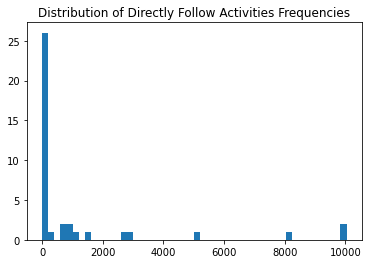

Read and preprocessed Event Log.....
Converting to Feature Set....



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Index(['Case ID', 'Start Timestamp', 'Complete Timestamp', 'Activity',
       'segment', 'Resource'],
      dtype='object')
Features added
2


Found `n_estimators` in params. Will use it instead of argument
Using categorical_feature in Dataset.
categorical_feature in param dict is overridden.


Training until validation scores don't improve for 100 rounds.
[50]	training's mape: 3.3443	valid_1's mape: 1.45849
[100]	training's mape: 3.11871	valid_1's mape: 1.38126
[150]	training's mape: 2.88054	valid_1's mape: 1.29309
[200]	training's mape: 2.75418	valid_1's mape: 1.2205
[250]	training's mape: 2.61659	valid_1's mape: 1.16751
Did not meet early stopping. Best iteration is:
[250]	training's mape: 2.61659	valid_1's mape: 1.16751


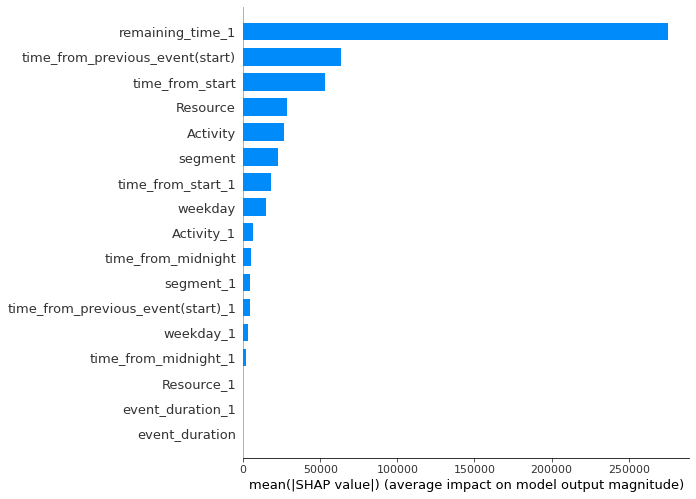

3


Found `n_estimators` in params. Will use it instead of argument
Using categorical_feature in Dataset.
categorical_feature in param dict is overridden.


Training until validation scores don't improve for 100 rounds.
[50]	training's mape: 3.00124	valid_1's mape: 1.40089
[100]	training's mape: 2.73732	valid_1's mape: 1.29801
[150]	training's mape: 2.52841	valid_1's mape: 1.24428
[200]	training's mape: 2.4211	valid_1's mape: 1.20333
[250]	training's mape: 2.31016	valid_1's mape: 1.13218
Did not meet early stopping. Best iteration is:
[250]	training's mape: 2.31016	valid_1's mape: 1.13218


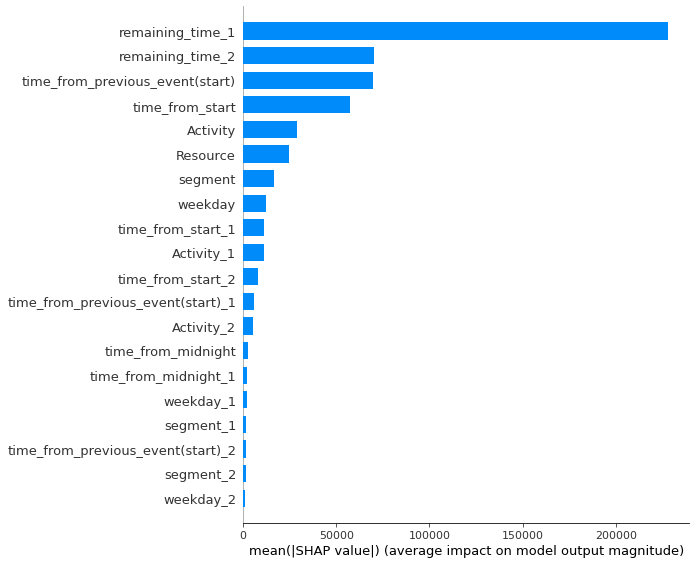

4


Found `n_estimators` in params. Will use it instead of argument
Using categorical_feature in Dataset.
categorical_feature in param dict is overridden.


Training until validation scores don't improve for 100 rounds.
[50]	training's mape: 2.92706	valid_1's mape: 1.32655
[100]	training's mape: 2.64078	valid_1's mape: 1.26887
[150]	training's mape: 2.43991	valid_1's mape: 1.21368
[200]	training's mape: 2.3012	valid_1's mape: 1.21176
[250]	training's mape: 2.21973	valid_1's mape: 1.14958
Did not meet early stopping. Best iteration is:
[232]	training's mape: 2.18451	valid_1's mape: 1.18261


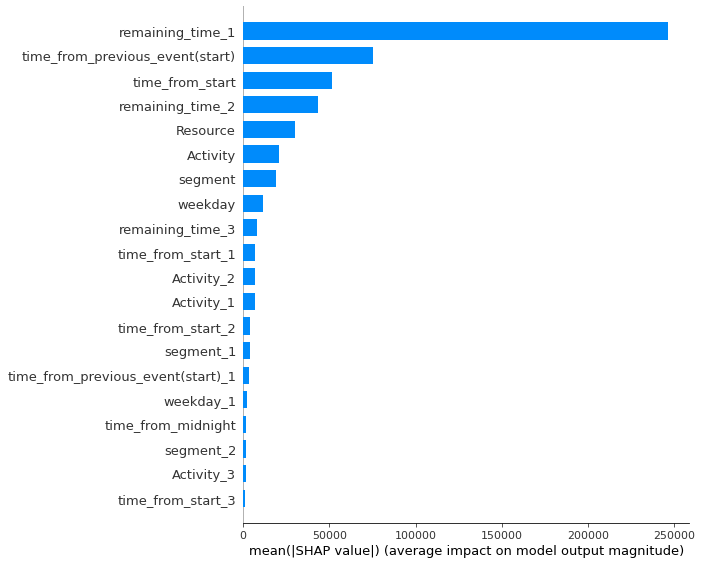

5


Found `n_estimators` in params. Will use it instead of argument
Using categorical_feature in Dataset.
categorical_feature in param dict is overridden.


Training until validation scores don't improve for 100 rounds.
[50]	training's mape: 2.99567	valid_1's mape: 1.3849
[100]	training's mape: 2.84146	valid_1's mape: 1.29027
[150]	training's mape: 2.72274	valid_1's mape: 1.2395
[200]	training's mape: 2.59311	valid_1's mape: 1.16507
[250]	training's mape: 2.45644	valid_1's mape: 1.11752
Did not meet early stopping. Best iteration is:
[250]	training's mape: 2.45644	valid_1's mape: 1.11752


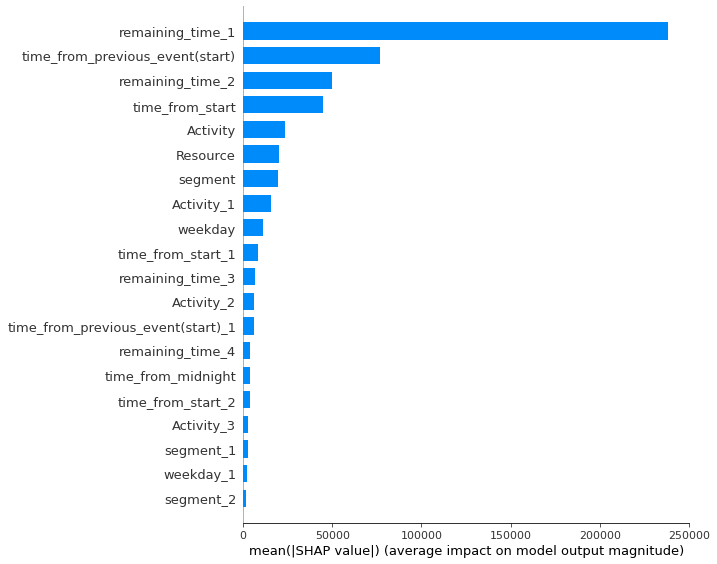

[2.3995851845008476, 2.38078209052614, 2.3702764609416955, 2.3714280929017315]
2.3771259249182535 0.009996164973059623


In [66]:
# Train model for measuring weighted average for each prefix
mae_days=[]
weights_p = []
file_name = 'prepared_data/bpi20.csv'
batch_delay = '1H'
segment_dict,dfg_activities_unique = get_dfg_activities(df)
dataframe = prepare_basic_data_for_prediction(file_name, batch_delay, segment_dict)
for i in range(2,6):
    target = "remaining_time"
    prefix_length = i
    print(i)
    data = create_sliding_windows(dataframe,prefix_length,target)
    split_index = int(0.20*data.shape[0])
    X,X_train,Y_train,X_test,Y_test = split_test_train_data(data, prefix_length,target,split_index)
    cat_cols = ["Activity","Resource", "segment"]
    X_train,Y_train,X_test,Y_test,categorical_cols = preprocess_test_train_data(X,X_train,Y_train,X_test,Y_test, prefix_length, cat_cols)
    mae,y_pred,model = train_model_1(X_train,Y_train,X_test,Y_test,categorical_cols)
    mae_days.append(mae)
    weights_p.append(i)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="bar")
print(mae_days)
w_mae_mean = np.average(mae_days,weights=weights_p)
variance = np.average((mae_days-w_mae_mean)**2, weights=weights_p)
print(w_mae_mean, math.sqrt(variance))

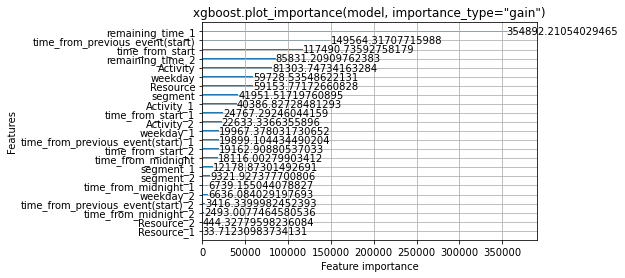

In [56]:
lgb.plot_importance(model, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()

# SHAP Values

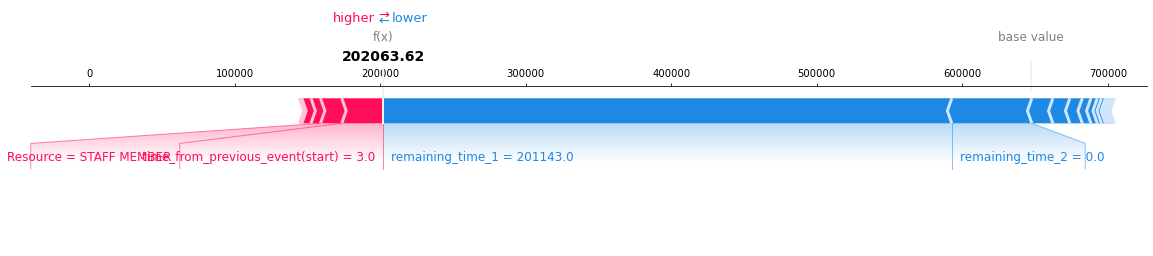

In [60]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
# X,y = shap.datasets.boston()
# model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[3,:], X_train.iloc[3,:],matplotlib=True,show=False)
plt.savefig("data/shap_data_ind.png",dpi=1200,bbox_inches='tight')

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)

shap.plots.force is slow for many thousands of rows, try subsampling your data.


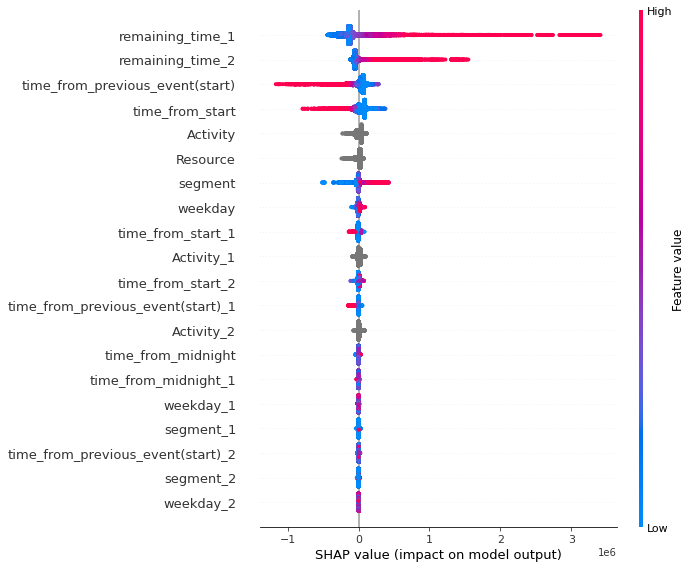

In [58]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train, show= False)
plt.savefig("data/shap_summary.png",dpi=1200,bbox_inches='tight')

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


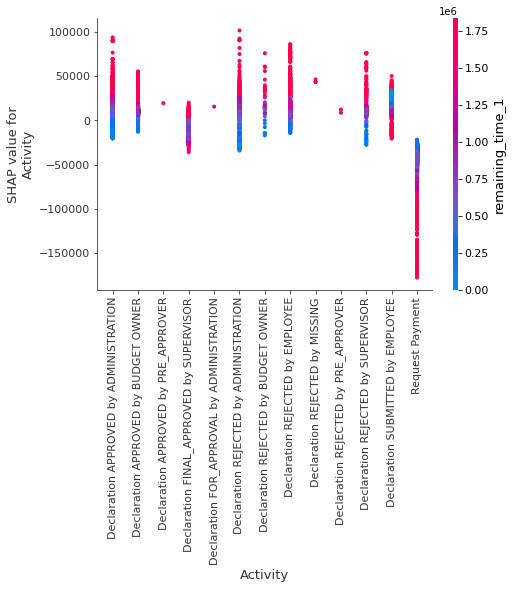

In [74]:
shap.dependence_plot("Activity", shap_values, X_train)

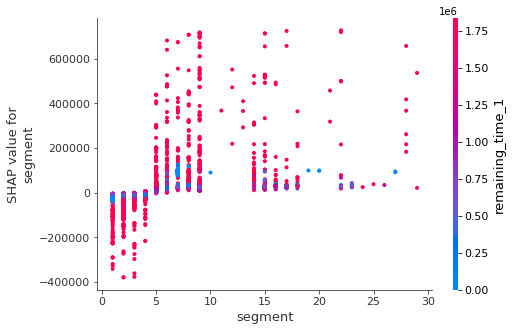

In [102]:
shap.dependence_plot("segment", shap_values, X_train)

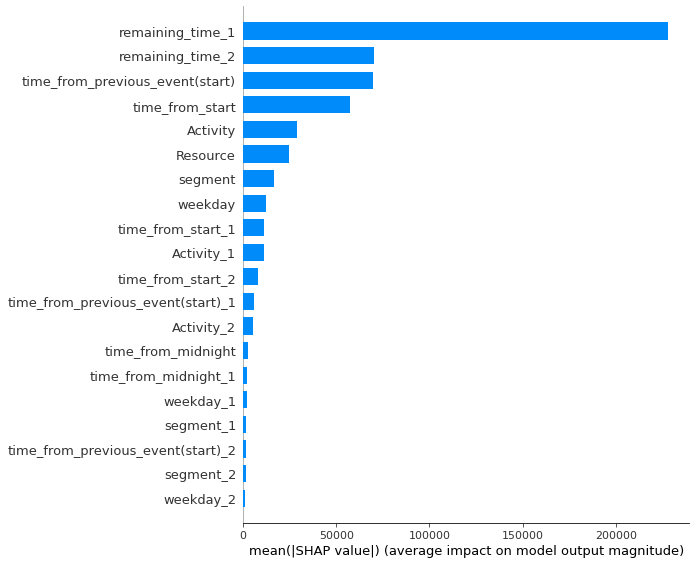

In [61]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

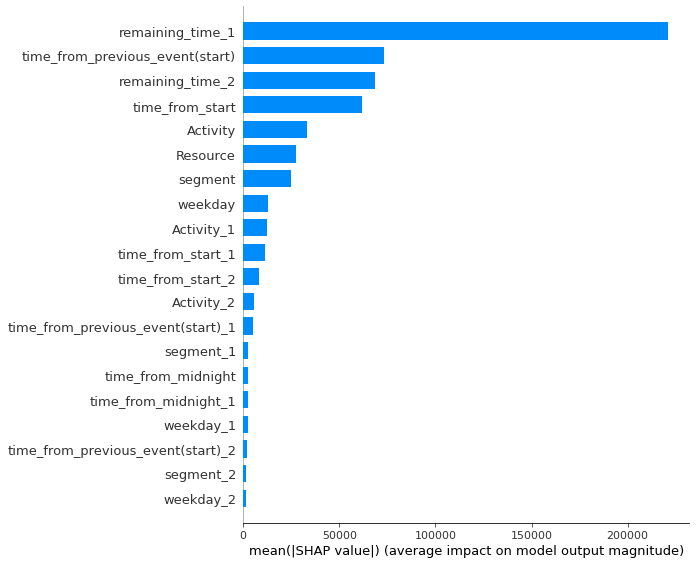

In [65]:
shap_values_test = explainer.shap_values(X_test)
shap.summary_plot(shap_values_test, X_test, plot_type="bar")

In [8]:
X_train.head()

NameError: name 'X_train' is not defined